In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error,r2_score
import matplotlib.pyplot as plt
import random

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgb


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 572.6/572.6 kB 10.4 MB/s eta 0:00:00


In [4]:
pip install lime

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 9.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283859 sha256=809502ac97343fc8f7382f19e4a5c51a7ffe49c687a739d2e7e59f7b06fd9390
  Stored in directory: /root/.cache/pip/wheels/fd/a2/af/9ac0a1a85a27f314a06b39e1f492bee1547d52549a4606ed89
Successfully built lime


In [5]:
#Importing the data file and showing the first 5 rows
data=pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Colab data/Customer Churn.csv')
data.head()

,Call Failure,Complains,Subscription Length,Charge Amount,Seconds of Use,Frequency of use,Frequency of SMS,Distinct Called Numbers,Age Group,Tariff Plan,Status,Age,Customer Value,FN,FP,Churn
0,8,0,38,0,4370,71,5,17,3,1,1,30,197.640,177.8760,69.7640,0
1,0,0,39,0,318,5,7,4,2,1,2,25,46.035,41.4315,60.0000,0
2,10,0,37,0,2453,60,359,24,3,1,1,30,1536.520,1382.8680,203.6520,0
3,10,0,38,0,4198,66,1,35,1,1,1,15,240.020,216.0180,74.0020,0
4,3,0,38,0,2393,58,2,33,1,1,1,15,145.805,131.2245,64.5805,0


In [6]:
#Creating Train and test data for the whole program
X=data.iloc[:,:-1]
y=data.iloc[:,-1]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42) #split the data for training and testing

In [7]:
#creating the model and then fitting the data
rf = RandomForestClassifier(n_estimators=100, random_state=42) 
rf.fit(X_train, y_train)
rf_pred = rf.predict(X_test)

clf = lgb.LGBMClassifier()
clf.fit(X_train, y_train)
lgbm_pred=clf.predict(X_test)

linreg = LinearRegression()
linreg.fit(X_train, y_train) 
linreg_pred = linreg.predict(X_test)


dtree = DecisionTreeClassifier() 
dtree.fit(X_train, y_train) 
dtree_pred = dtree.predict(X_test)


#finding the accuracy metrics for each model
rf_mae = mean_absolute_error(y_test, rf_pred)
rf_mse = mean_squared_error(y_test, rf_pred)
rf_r2 = r2_score(y_test, rf_pred)

clf_mae = mean_absolute_error(y_test, lgbm_pred)
clf_mse = mean_squared_error(y_test, lgbm_pred)
clf_r2 = r2_score(y_test, lgbm_pred)

lr_mae = mean_absolute_error(y_test, linreg_pred)
lr_mse = mean_squared_error(y_test, linreg_pred)
lr_r2 = r2_score(y_test, linreg_pred)

dt_mae = mean_absolute_error(y_test, dtree_pred)
dt_mse = mean_squared_error(y_test, dtree_pred)
dt_r2 = r2_score(y_test, dtree_pred)

#now that we have the metrics, we put them up in a tabular form

data = {
  
  "R2": [lr_r2,dt_r2,clf_r2,rf_r2],
  "MSE": [lr_mse,dt_mse,clf_mse,rf_mse],
  "MAE": [lr_mae,dt_mae,clf_mae,rf_mae]
}


metrics_table=pd.DataFrame(data,index=["LR", "DT","LGBM","RF"])
metrics_table.head()



,R2,MSE,MAE
LR,0.426568,0.081451,0.169598
DT,0.515751,0.068783,0.068783
LGBM,0.657301,0.048677,0.048677
RF,0.605151,0.056085,0.056085


We can clearly notice that the accuracy metric get better as we move on from Open Box models to Black Box Models. (R2 increases, MSE and MAE decreases)

Permutation explainer: 2206it [29:58,  1.22it/s]


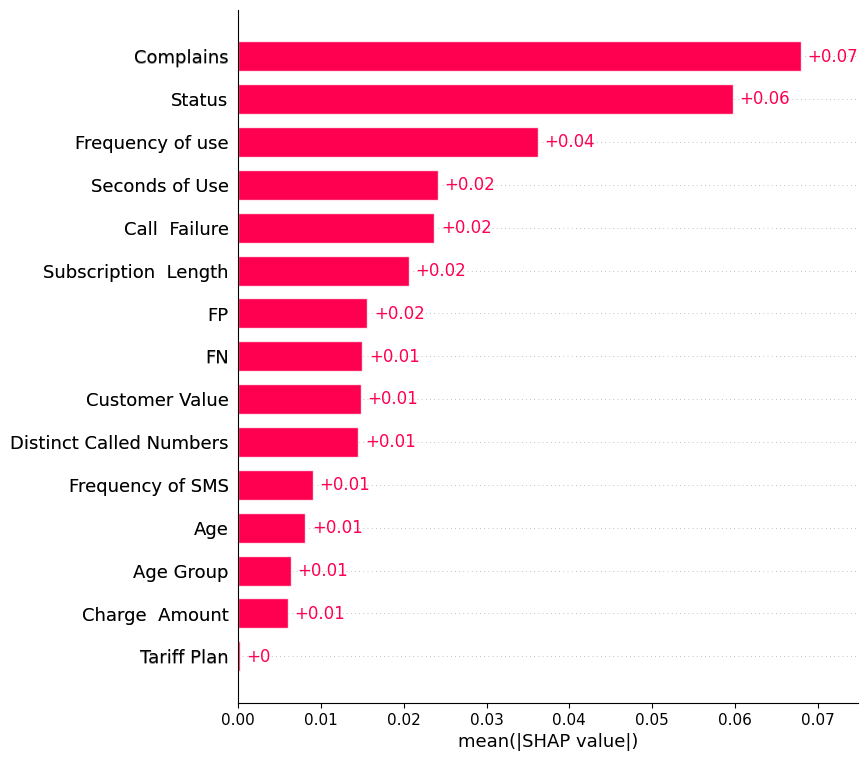

In [9]:
#SHAP
import shap

explainer = shap.Explainer(rf.predict, X_test)
shap_values = explainer(X_train)

shap.plots.bar(shap_values,max_display=20) 
#This bar plot shows the shap values as a bar plot 


No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


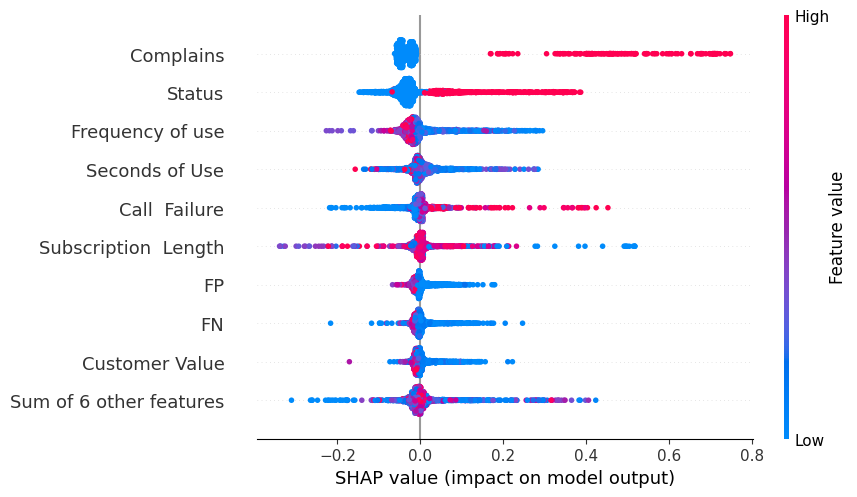

In [10]:
shap.plots.beeswarm(shap_values)

In [11]:
vals= np.abs(shap_values.values).mean(0)

feature_importance = pd.DataFrame(list(zip(X_train.columns,vals)), columns=['col_name','feature_importance_vals'])
feature_importance.sort_values(by=['feature_importance_vals'], ascending=False,inplace=True)

col_list=feature_importance['col_name'].to_list() #this list contains the names of the features in the decreasing order of shop values


In [12]:
# function defined to return the top n important features
def return_n_imp(n):
  return col_list[0:n]

In [14]:
from lime.lime_tabular import LimeTabularExplainer


from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_normalized_arr=scaler.transform(X_train)
X_train_normalized_df=pd.DataFrame(X_train_normalized_arr, columns=list(X.columns))

X_test_normalized_arr=scaler.transform(X_test)
X_test_normalized_df=pd.DataFrame(X_test_normalized_arr, columns=list(X.columns))


from sklearn.neural_network import MLPClassifier

# create a multi-layer perceptron classifier with one hidden layer
mlp = MLPClassifier(hidden_layer_sizes=(100,), alpha=0.0001)

# fit the model on the training data
mlp.fit(X_train_normalized_df, y_train)

# evaluate the model on the test data
accuracy = mlp.score(X_test_normalized_df, y_test)
print("Test accuracy:", accuracy)

explainer = LimeTabularExplainer(X_train_normalized_df.values, 
                                   feature_names=X_train_normalized_df.columns, 
                                   class_names=['not_churn','churn'], 
                                   verbose=True, 
                                   mode='classification')



Test accuracy: 0.8920634920634921


Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.


In [15]:
def return_weights(exp):
    
    """Get weights from LIME explanation object"""
    
    exp_list = exp.as_map()[1]
    exp_list = sorted(exp_list, key=lambda x: x[0])
    exp_weight = [x[1] for x in exp_list]
    
    return exp_weight

def imp(model, name,n):

  weights = []

  #Iterate over first 100 rows in feature matrix
  for x in X_test_normalized_df.values[0:100]:
      
      #Get explanation
      exp = explainer.explain_instance(x, 
                                  model.predict_proba, 
                                  num_features=15, 
                                  )
      
      #Get weights
      exp_weight = return_weights(exp)
      weights.append(exp_weight)
      
  #Create DataFrame
  lime_weights = pd.DataFrame(data=weights,columns=X_test_normalized_df.columns)
  print(lime_weights)
    #Get abs mean of LIME weights
  abs_mean = lime_weights.abs().mean(axis=0)
  abs_mean = pd.DataFrame(data={'feature':abs_mean.index, 'abs_mean':abs_mean})
  abs_mean = abs_mean.sort_values('abs_mean')

  #Plot abs mean
  ''' fig, ax = plt.subplots(nrows=1, ncols=1,figsize=(8,8)) '''

  ''' y_ticks = range(len(abs_mean))
  y_labels = abs_mean.feature
  plt.barh(y=y_ticks,width=abs_mean.abs_mean)

  plt.yticks(ticks=y_ticks,labels=y_labels,size= 15)
  plt.title('')
  plt.ylabel('')
  plt.xlabel("Mean |Weight| {}".format(name),size=20) '''

  last_n_index = abs_mean.tail(n).index.astype(str).tolist()
  last_n_index.reverse()
  return last_n_index

In [16]:
mlp_labels_lime = imp(rf,"random_forest",4)#testing

X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9955516411035397
Prediction_local [0.91104163]
Right: 0.93
Intercept 0.9945464711496883
Prediction_local [0.91100837]
Right: 0.9


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9868283169474199
Prediction_local [0.9298316]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9922186729098236
Prediction_local [0.91858311]
Right: 0.92


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9925535606617695
Prediction_local [0.91909505]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9959356139215085
Prediction_local [0.90668045]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9957571351982318
Prediction_local [0.9111319]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9892307703099861
Prediction_local [0.92458784]
Right: 0.92


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.99404244995211
Prediction_local [0.91576689]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9869763320540609
Prediction_local [0.92880036]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9897328670480915
Prediction_local [0.92437434]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9874400335421342
Prediction_local [0.92836776]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9914711019561788
Prediction_local [0.92276127]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9922799550829821
Prediction_local [0.91519006]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9888542881464052
Prediction_local [0.92885774]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9892961787566504
Prediction_local [0.92848185]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9210853510905652
Prediction_local [0.99544168]
Right: 0.99


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9876098291727375
Prediction_local [0.9288093]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9879008487008105
Prediction_local [0.93040825]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9885631256301021
Prediction_local [0.93086124]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9885409712025486
Prediction_local [0.9244881]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9885648832621118
Prediction_local [0.9291963]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9870867139020291
Prediction_local [0.93101515]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9915276943288285
Prediction_local [0.92415712]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9868592917809996
Prediction_local [0.9289959]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.988075543123292
Prediction_local [0.92969652]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9885453822587308
Prediction_local [0.92967696]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9241007747829298
Prediction_local [0.99044819]
Right: 0.99


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9870137775300682
Prediction_local [0.93112648]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9880617362807739
Prediction_local [0.92903285]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9883407759424089
Prediction_local [0.92942046]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9924084137840689
Prediction_local [0.91992915]
Right: 0.92


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9920682239127321
Prediction_local [0.91525401]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9890079719564036
Prediction_local [0.92568519]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9919972211984784
Prediction_local [0.91632817]
Right: 0.9
Intercept 0.9954254356708452
Prediction_local [0.91146534]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9885201464594887
Prediction_local [0.92889476]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.986607648782686
Prediction_local [0.92874926]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9911860267949453
Prediction_local [0.92463222]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9890425220015934
Prediction_local [0.92936797]
Right: 0.93
Intercept 0.9887521081221298
Prediction_local [0.92913772]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9907020052015533
Prediction_local [0.9247123]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9886265381513144
Prediction_local [0.92864404]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9872573267220908
Prediction_local [0.92940125]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9882873438208791
Prediction_local [0.92943793]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9917627191226193
Prediction_local [0.91828891]
Right: 0.92


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9890828576521589
Prediction_local [0.92452058]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9950825651532919
Prediction_local [0.91137473]
Right: 0.9


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9924256749625451
Prediction_local [0.91948665]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9883292484803888
Prediction_local [0.92947636]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9929432403570913
Prediction_local [0.91656556]
Right: 0.9


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9918766845293729
Prediction_local [0.9164961]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9976452107751268
Prediction_local [0.90532448]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9934558592308637
Prediction_local [0.91969113]
Right: 0.92


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9921997893597926
Prediction_local [0.91421235]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9859312389115109
Prediction_local [0.93015611]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9876045466163508
Prediction_local [0.92784413]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9919859421150392
Prediction_local [0.92029173]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9957274850136906
Prediction_local [0.90610186]
Right: 0.92


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9890342682071523
Prediction_local [0.92404232]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9859269794884309
Prediction_local [0.93121939]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9932786730030849
Prediction_local [0.91940581]
Right: 0.89
Intercept 0.9907933295180977
Prediction_local [0.92592528]
Right: 0.92


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9899481370070139
Prediction_local [0.92886428]
Right: 0.93
Intercept 0.9881960357746805
Prediction_local [0.92990853]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9201726170289748
Prediction_local [0.99612044]
Right: 0.99


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9872357892593073
Prediction_local [0.93071251]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9873505678631731
Prediction_local [0.92830156]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9878986465675583
Prediction_local [0.92934835]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9899456404917775
Prediction_local [0.92658468]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9925534553202985
Prediction_local [0.91642697]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9893933920469313
Prediction_local [0.92560607]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9874099348691856
Prediction_local [0.9300297]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9889993514585471
Prediction_local [0.92912934]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9869743295611642
Prediction_local [0.92987503]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.996150062121462
Prediction_local [0.9074307]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9879736228719386
Prediction_local [0.92937692]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9900478403358718
Prediction_local [0.92828934]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9959833875903833
Prediction_local [0.90709723]
Right: 0.93
Intercept 0.9877664535543769
Prediction_local [0.92891677]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9923863562606071
Prediction_local [0.91818138]
Right: 0.93
Intercept 0.996317744449468
Prediction_local [0.90551904]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9887035081140972
Prediction_local [0.92824837]
Right: 0.93
Intercept 0.9867539811421397
Prediction_local [0.929877]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9921974892369988
Prediction_local [0.91914198]
Right: 0.89
Intercept 0.9932870072406109
Prediction_local [0.91516194]
Right: 0.9


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9874951424298198
Prediction_local [0.93030786]
Right: 0.93
Intercept 0.9931539167437302
Prediction_local [0.91447403]
Right: 0.9


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9883799029477749
Prediction_local [0.9288956]
Right: 0.93
Intercept 0.9875799846187382
Prediction_local [0.92964729]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9903905486540954
Prediction_local [0.92313213]
Right: 0.93
Intercept 0.9917260541316604
Prediction_local [0.9171236]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.989238002060134
Prediction_local [0.92797056]
Right: 0.93
Intercept 0.9889543795997595
Prediction_local [0.93001587]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9899691423242197
Prediction_local [0.92347641]
Right: 0.92
Intercept 0.9872284456382705
Prediction_local [0.93060606]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9881789361178968
Prediction_local [0.93084825]
Right: 0.93
Intercept 0.9196277864244369
Prediction_local [0.99678413]
Right: 0.99


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9911511549058418
Prediction_local [0.91746497]
Right: 0.93
Intercept 0.9882029702769007
Prediction_local [0.9288927]
Right: 0.93
    Call  Failure  Complains  Subscription  Length  Charge  Amount  \
0        0.000309  -0.066601              0.000488       -0.005108   
1       -0.000785  -0.067381              0.000453        0.002952   
2        0.000417  -0.066399             -0.000539        0.003120   
3       -0.000052  -0.067336              0.000054       -0.005206   
4       -0.000119  -0.067915             -0.000444       -0.005466   
..            ...        ...                   ...             ...   
95      -0.000209  -0.066941              0.000228        0.003001   
96      -0.000119  -0.067371              0.000298        0.002872   
97      -0.000416   0.067426             -0.000793        0.002864   
98       0.000068  -0.066760              0.000423        0.002774   
99      -0.000606  -0.067243              0.000288        0.002820   

    Seconds of Use

X does not have valid feature names, but RandomForestClassifier was fitted with feature names


In [17]:
#defining the errors as functions
MSE=mean_squared_error(y_test,rf.predict(X_test))
MAE=mean_absolute_error(y_test,rf.predict(X_test))
R2=r2_score(y_test,rf.predict(X_test))
print(MSE,MAE,R2)#errors with all features
r2n=np.zeros(15)
maen=np.zeros(15)
msen=np.zeros(15)
Dn=np.zeros(15)

0.056084656084656084 0.056084656084656084 0.6051511281396338


In [18]:
for i in range(15):

  X1_train=X_train.drop(return_n_imp(i),axis=1)
  X1_test=X_test.drop(return_n_imp(i),axis=1)
  rf1 = RandomForestClassifier(n_estimators=100, random_state=42) #create the model
  rf1.fit(X1_train, y_train)
  MSE1=mean_squared_error(y_test,rf1.predict(X1_test))
  MAE1=mean_absolute_error(y_test,rf1.predict(X1_test))
  R21=r2_score(y_test,rf1.predict(X1_test))
  r2n[i]=R21
  maen[i]=MAE1
  msen[i]=MSE1
  #Dn[i]=MSE1+MAE1-R21+R2-MAE-MSE
  #Dn[i]=R2-R21+(MSE1-MSE)

In [19]:
X1_train=X_train.drop(return_n_imp(7),axis=1)
X1_train#testing the dropping of features

,Charge Amount,Frequency of SMS,Distinct Called Numbers,Age Group,Tariff Plan,Age,Customer Value,FN
3082,2,11,4,5,1,55,26.295,23.6655
1454,0,0,26,1,1,15,107.360,96.6240
1498,0,197,3,3,1,30,945.240,850.7160
2561,0,36,34,3,1,30,272.520,245.2680
549,0,0,3,3,1,30,35.880,32.2920
...,...,...,...,...,...,...,...,...
3092,1,26,15,2,1,25,187.560,168.8040
1095,0,78,40,1,2,15,771.265,694.1385
1130,1,12,22,4,1,45,195.850,176.2650
1294,0,11,8,2,1,25,109.260,98.3340


Text(0.5, 1.0, 'R2 vs features')

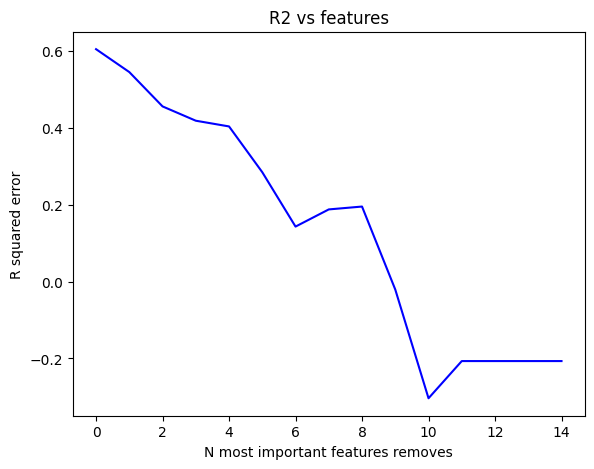

In [20]:
figr2 = plt.figure()


axesr2 = figr2.add_axes([0.1, 0.1, 0.8, 0.8]) 


axesr2.plot(list(range(0,15)), r2n, 'b')
axesr2.set_xlabel('N most important features removes') 
axesr2.set_ylabel('R squared error')
axesr2.set_title('R2 vs features')

Text(0.5, 1.0, 'MAE vs features')

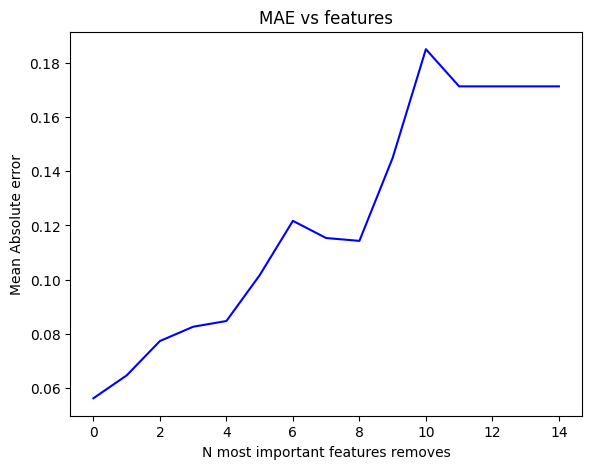

In [21]:
figmea = plt.figure()


axesmea = figmea.add_axes([0.1, 0.1, 0.8, 0.8]) 


axesmea.plot(list(range(0,15)), maen, 'b')
axesmea.set_xlabel('N most important features removes') 
axesmea.set_ylabel('Mean Absolute error')
axesmea.set_title('MAE vs features')

Text(0.5, 1.0, 'MSE vs features')

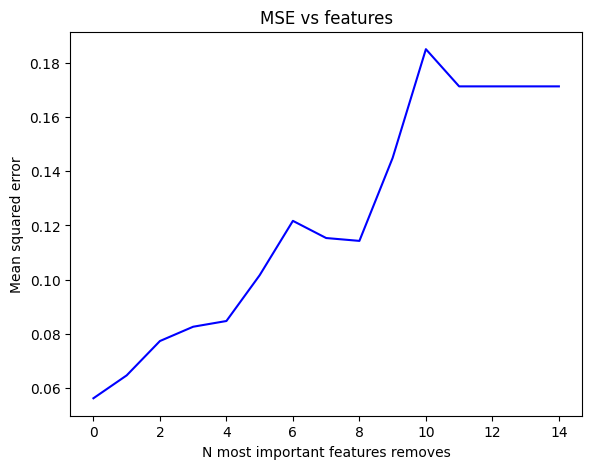

In [22]:
figmse = plt.figure()


axesmse = figmse.add_axes([0.1, 0.1, 0.8, 0.8]) 


axesmse.plot(list(range(0,15)), msen, 'b')
axesmse.set_xlabel('N most important features removes') 
axesmse.set_ylabel('Mean squared error')
axesmse.set_title('MSE vs features')

In [23]:
nmse=msen[14]-msen[0]#range of errors
nmae=maen[14]-maen[0]
for i in range(15):

  X1_train=X_train.drop(return_n_imp(i),axis=1)
  X1_test=X_test.drop(return_n_imp(i),axis=1)
  rf1 = RandomForestClassifier(n_estimators=100, random_state=42) #create the model
  rf1.fit(X1_train, y_train)
  MSE1=mean_squared_error(y_test,rf1.predict(X1_test))
  MAE1=mean_absolute_error(y_test,rf1.predict(X1_test))
  R21=r2_score(y_test,rf1.predict(X1_test))
  #Dn[i]=MSE1+MAE1-R21+R2-MAE-MSE
  Dn[i]=R2-R21+(MSE1-MSE)/nmse +(MAE1-MAE)/nmae#including normalisation

Text(0.5, 1.0, 'D vs features')

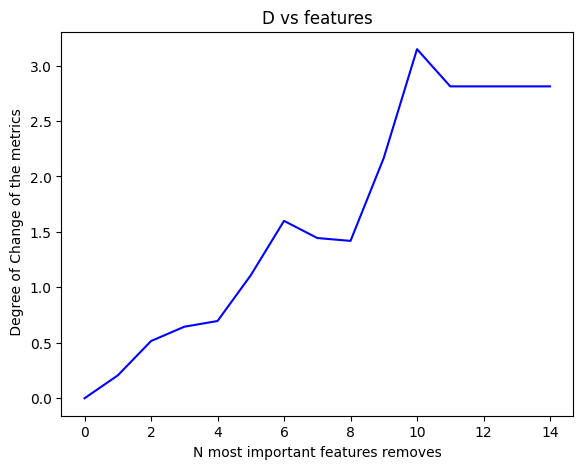

In [24]:
figD = plt.figure()


axesD = figD.add_axes([0.1, 0.1, 0.8, 0.8]) 


axesD.plot(list(range(0,15)), Dn, 'b')
axesD.set_xlabel('N most important features removes') 
axesD.set_ylabel(' Degree of Change of the metrics')
axesD.set_title('D vs features')

In [28]:
x=random.sample(range(15),15)#creating random sequence of features

r2r=np.zeros(15)
maer=np.zeros(15)
mser=np.zeros(15)
D2=np.zeros(15)
print(x)

[0, 14, 3, 4, 7, 13, 8, 11, 5, 10, 6, 12, 1, 9, 2]


In [29]:
for i in range(15):

  X2_train=X_train.drop(X_test.columns[x[0:i]],axis=1)
  X2_test=X_test.drop(X_test.columns[x[0:i]],axis=1)
  rf2 = RandomForestClassifier(n_estimators=100, random_state=42) #create the model
  rf2.fit(X2_train, y_train)
  MSE2=mean_squared_error(y_test,rf2.predict(X2_test))
  MAE2=mean_absolute_error(y_test,rf2.predict(X2_test))
  R22=r2_score(y_test,rf2.predict(X2_test))
  r2r[i]=R22
  maer[i]=MAE2
  mser[i]=MSE2
  #Dn[i]=MSE1+MAE1-R21+R2-MAE-MSE
  #Dn[i]=R2-R21+(MSE1-MSE)

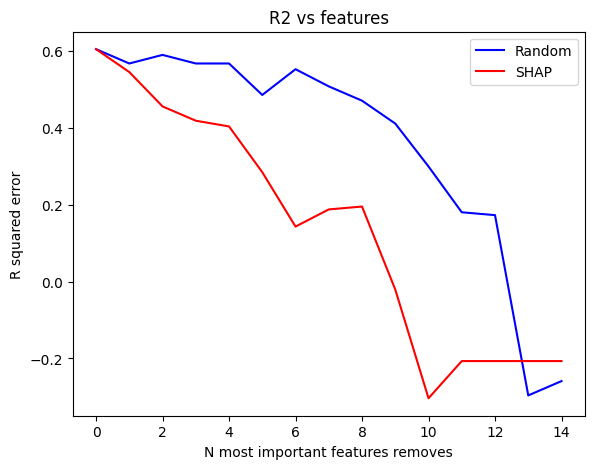

In [30]:
figr2r = plt.figure()


axesr2r = figr2r.add_axes([0.1, 0.1, 0.8, 0.8]) 


axesr2r.plot(list(range(0,15)), r2r, 'b',label='Random')
axesr2r.plot(list(range(0,15)), r2n, 'r',label='SHAP')
axesr2r.set_xlabel('N most important features removes') 
axesr2r.set_ylabel('R squared error')
axesr2r.set_title('R2 vs features')
axesr2r.legend()

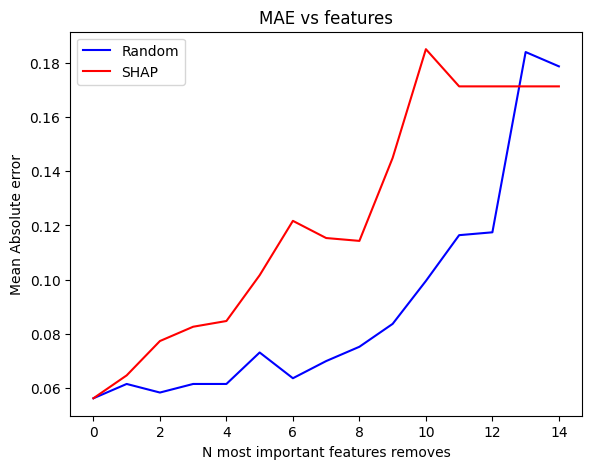

In [31]:
figmear = plt.figure()


axesmear = figmear.add_axes([0.1, 0.1, 0.8, 0.8]) 


axesmear.plot(list(range(0,15)), maer, 'b',label='Random')
axesmear.plot(list(range(0,15)), maen, 'r',label='SHAP')
axesmear.set_xlabel('N most important features removes') 
axesmear.set_ylabel('Mean Absolute error')
axesmear.set_title('MAE vs features')
axesmear.legend()

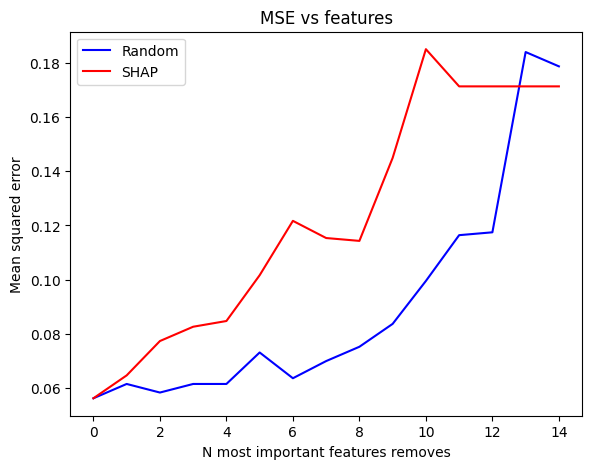

In [32]:
figmser = plt.figure()


axesmser = figmser.add_axes([0.1, 0.1, 0.8, 0.8]) 


axesmser.plot(list(range(0,15)), mser, 'b',label='Random')
axesmser.plot(list(range(0,15)), msen, 'r',label='SHAP')
axesmser.set_xlabel('N most important features removes') 
axesmser.set_ylabel('Mean squared error')
axesmser.set_title('MSE vs features')
axesmser.legend()

In [34]:
rmse=mser[14]-mser[0]
rmae=maer[14]-maer[0]
for i in range(15):

  X2_train=X_train.drop(X_test.columns[x[0:i]],axis=1)
  X2_test=X_test.drop(X_test.columns[x[0:i]],axis=1)
  rf2 = RandomForestClassifier(n_estimators=100, random_state=42) #create the model
  rf2.fit(X2_train, y_train)
  MSE2=mean_squared_error(y_test,rf2.predict(X2_test))
  MAE2=mean_absolute_error(y_test,rf2.predict(X2_test))
  R22=r2_score(y_test,rf2.predict(X2_test))
  #Dn[i]=MSE1+MAE1-R21+R2-MAE-MSE
  D2[i]=R2-R22+(MSE2-MSE)/rmse +(MAE2-MAE)/rmae

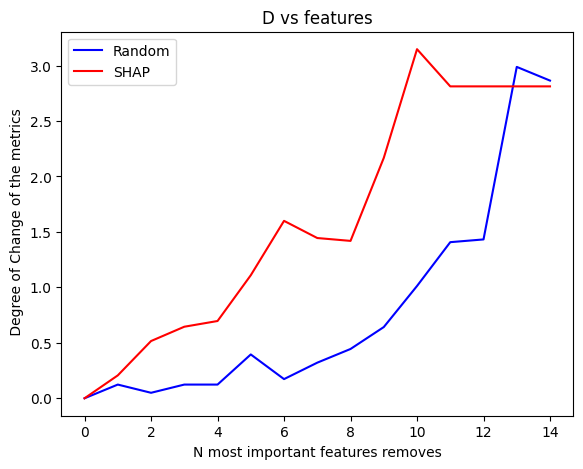

In [48]:
figDr = plt.figure()


axesDr = figDr.add_axes([0.1, 0.1, 0.8, 0.8]) 


axesDr.plot(list(range(0,15)), D2, 'b',label='Random')
axesDr.plot(list(range(0,15)), Dn, 'r',label='SHAP')
axesDr.set_xlabel('N most important features removes') 
axesDr.set_ylabel(' Degree of Change of the metrics')
axesDr.set_title('D vs features')
axesDr.legend()

In [36]:
r2l=np.zeros(15)
mael=np.zeros(15)
msel=np.zeros(15)
Dl=np.zeros(15)


In [39]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

for i in range(15):
  a=imp(rf,"random_forest",i)
  X3_train=X_train.drop(a,axis=1)
  X3_test=X_test.drop(a,axis=1)
  rf3 = RandomForestClassifier(n_estimators=100, random_state=42) #create the model
 
  rf3.fit(X3_train, y_train)
  
  MSE3=mean_squared_error(y_test,rf3.predict(X3_test))
  MAE3=mean_absolute_error(y_test,rf3.predict(X3_test))
  R23=r2_score(y_test,rf3.predict(X3_test))
  r2l[i]=R23
  mael[i]=MAE3
  msel[i]=MSE3
  #Dn[i]=MSE1+MAE1-R21+R2-MAE-MSE
  #Dn[i]=R2-R21+(MSE1-MSE)

X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9944267136170811
Prediction_local [0.91299467]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9924990536343985
Prediction_local [0.91125798]
Right: 0.9


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9870887915851415
Prediction_local [0.9303102]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9911540418727691
Prediction_local [0.91993988]
Right: 0.92


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9915260114850222
Prediction_local [0.91940711]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9964192277354071
Prediction_local [0.90513137]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.99309696728005
Prediction_local [0.91196931]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9907294047420692
Prediction_local [0.92402192]
Right: 0.92


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9941252038122118
Prediction_local [0.91489577]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9873479933314292
Prediction_local [0.9301881]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9908215814137457
Prediction_local [0.92357579]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9869689198993477
Prediction_local [0.92991472]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9900671566554247
Prediction_local [0.92496365]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.991792803687503
Prediction_local [0.9178618]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9876039446337525
Prediction_local [0.92995912]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9887240190656924
Prediction_local [0.92935958]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9201714712810859
Prediction_local [0.99753888]
Right: 0.99
Intercept 0.9871817826604425
Prediction_local [0.93006521]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9903117194735908
Prediction_local [0.92789757]
Right: 0.93
Intercept 0.9896105642564919
Prediction_local [0.92753157]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9895288768386536
Prediction_local [0.92465059]
Right: 0.93
Intercept 0.9874775747820694
Prediction_local [0.92995383]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9879802498836988
Prediction_local [0.93064101]
Right: 0.93
Intercept 0.9921108982804034
Prediction_local [0.92366204]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9873230136273256
Prediction_local [0.92899207]
Right: 0.93
Intercept 0.9872269399472687
Prediction_local [0.92940852]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.987746186933325
Prediction_local [0.93086697]
Right: 0.93
Intercept 0.9233717780027512
Prediction_local [0.99115712]
Right: 0.99


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9863969177277604
Prediction_local [0.93059177]
Right: 0.93
Intercept 0.9881553108180869
Prediction_local [0.9289678]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9890677706393026
Prediction_local [0.92886931]
Right: 0.93
Intercept 0.9925497258730172
Prediction_local [0.91917393]
Right: 0.92


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9930852430933415
Prediction_local [0.91628886]
Right: 0.93
Intercept 0.9900585972721286
Prediction_local [0.9257488]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9928319231894938
Prediction_local [0.91580376]
Right: 0.9
Intercept 0.9955539864440027
Prediction_local [0.91194795]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.987320073610132
Prediction_local [0.92947626]
Right: 0.93
Intercept 0.9864230882734307
Prediction_local [0.92948248]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9897010491362102
Prediction_local [0.92450241]
Right: 0.93
Intercept 0.9892366908656164
Prediction_local [0.92897521]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9876175800036694
Prediction_local [0.92965772]
Right: 0.93
Intercept 0.9904309043708452
Prediction_local [0.92499069]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.988938058877961
Prediction_local [0.92874185]
Right: 0.93
Intercept 0.9875158410267388
Prediction_local [0.92890697]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9884534148242651
Prediction_local [0.92825429]
Right: 0.93
Intercept 0.9909461700569671
Prediction_local [0.92223451]
Right: 0.92


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9905554601994995
Prediction_local [0.92371229]
Right: 0.93
Intercept 0.9962585234506842
Prediction_local [0.90859369]
Right: 0.9


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9920391924948131
Prediction_local [0.91959637]
Right: 0.93
Intercept 0.9884448583100824
Prediction_local [0.9303609]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9927834246167241
Prediction_local [0.91452972]
Right: 0.9
Intercept 0.9919331160570845
Prediction_local [0.91602621]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9974001419388232
Prediction_local [0.9059866]
Right: 0.93
Intercept 0.9930394491012644
Prediction_local [0.91887915]
Right: 0.92


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9917404659926754
Prediction_local [0.91658838]
Right: 0.93
Intercept 0.9876755685134015
Prediction_local [0.92943466]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9864930928036877
Prediction_local [0.93038654]
Right: 0.93
Intercept 0.991569428381251
Prediction_local [0.91814062]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9963780829364831
Prediction_local [0.90749508]
Right: 0.92
Intercept 0.9900718895191217
Prediction_local [0.92355735]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9879241567941786
Prediction_local [0.92820527]
Right: 0.93
Intercept 0.9914806113944835
Prediction_local [0.91943977]
Right: 0.89


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9908943456235301
Prediction_local [0.92468778]
Right: 0.92
Intercept 0.989426740103584
Prediction_local [0.92928241]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9883942358167033
Prediction_local [0.92950379]
Right: 0.93
Intercept 0.9199307538209924
Prediction_local [0.99645109]
Right: 0.99


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9877681050523762
Prediction_local [0.92898411]
Right: 0.93
Intercept 0.9874539506332457
Prediction_local [0.93029716]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9875329841363654
Prediction_local [0.92931563]
Right: 0.93
Intercept 0.9869781668432849
Prediction_local [0.92937728]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.993481322463988
Prediction_local [0.9170059]
Right: 0.93
Intercept 0.9888699273888211
Prediction_local [0.9231788]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9879894212301051
Prediction_local [0.9273873]
Right: 0.93
Intercept 0.9885166859382919
Prediction_local [0.92953619]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9886608658734187
Prediction_local [0.92889263]
Right: 0.93
Intercept 0.9961474464702309
Prediction_local [0.90584078]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9874523949447627
Prediction_local [0.93027768]
Right: 0.93
Intercept 0.9891720549564418
Prediction_local [0.92955476]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9975904157240517
Prediction_local [0.90740553]
Right: 0.93
Intercept 0.9882247122482865
Prediction_local [0.92920427]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9934947281093665
Prediction_local [0.91730171]
Right: 0.93
Intercept 0.9968034378409059
Prediction_local [0.90655784]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9883435109008929
Prediction_local [0.92983927]
Right: 0.93
Intercept 0.9885713158283982
Prediction_local [0.92999727]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9922236657745205
Prediction_local [0.91949738]
Right: 0.89
Intercept 0.9927949227036182
Prediction_local [0.91523323]
Right: 0.9


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9884401091179843
Prediction_local [0.92801416]
Right: 0.93
Intercept 0.9931829652649437
Prediction_local [0.91497581]
Right: 0.9


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9890430759322898
Prediction_local [0.92889095]
Right: 0.93
Intercept 0.9878468833072385
Prediction_local [0.92874207]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9920936440033945
Prediction_local [0.91994271]
Right: 0.93
Intercept 0.9922415243982946
Prediction_local [0.91586487]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9877268729962215
Prediction_local [0.93010291]
Right: 0.93
Intercept 0.9873422182056071
Prediction_local [0.92937119]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9904759707019062
Prediction_local [0.92327736]
Right: 0.92
Intercept 0.9873991395757734
Prediction_local [0.93004201]
Right: 0.93
Intercept 0.9868441801053531
Prediction_local [0.92996801]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9193756998360121
Prediction_local [0.99779896]
Right: 0.99


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9924047636364032
Prediction_local [0.9151912]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9867353145302591
Prediction_local [0.93040755]
Right: 0.93
    Call  Failure  Complains  Subscription  Length  Charge  Amount  \
0        0.000263  -0.067152             -0.000050       -0.004337   
1        0.000474  -0.066517             -0.000144        0.002737   
2        0.000916  -0.066730             -0.000002        0.003105   
3       -0.000288  -0.066507              0.000418       -0.003973   
4       -0.000010  -0.066933             -0.000219       -0.004622   
..            ...        ...                   ...             ...   
95       0.000651  -0.066523              0.000158        0.002744   
96      -0.000005  -0.066815              0.000377        0.002636   
97      -0.000218   0.066812             -0.000031        0.002956   
98      -0.000575  -0.066831              0.000113        0.002879   
99       0.000670  -0.066766             -0.000490        0.002806   

    Seconds of Use  Frequency of use  Frequency of SMS  \
0        -0.000230          0.

X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9944323735435175
Prediction_local [0.91223141]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9948240054412487
Prediction_local [0.91088302]
Right: 0.9


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9874507611582243
Prediction_local [0.92957828]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9919462683032215
Prediction_local [0.9198571]
Right: 0.92


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9912169155020981
Prediction_local [0.92106536]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9961607328525197
Prediction_local [0.90598407]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9957342493152656
Prediction_local [0.91035635]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9900784689327476
Prediction_local [0.92449438]
Right: 0.92
Intercept 0.9938907529374315
Prediction_local [0.91599335]
Right: 0.93
Intercept 0.9871462418891928
Prediction_local [0.92993388]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9904535423080478
Prediction_local [0.92481608]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9882962765767277
Prediction_local [0.92889657]
Right: 0.93
Intercept 0.9909960049869012
Prediction_local [0.92401659]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9916664637531034
Prediction_local [0.91756555]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9882769838678295
Prediction_local [0.92905004]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9897531255167448
Prediction_local [0.92977317]
Right: 0.93
Intercept 0.9211615328559603
Prediction_local [0.9960159]
Right: 0.99


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9876998396720046
Prediction_local [0.92911143]
Right: 0.93
Intercept 0.9869836640908725
Prediction_local [0.92964884]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9883762902031653
Prediction_local [0.93134797]
Right: 0.93
Intercept 0.990176210031261
Prediction_local [0.92344001]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9879166644859149
Prediction_local [0.92976759]
Right: 0.93
Intercept 0.987559287470142
Prediction_local [0.93008581]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9908600604203408
Prediction_local [0.92435861]
Right: 0.93
Intercept 0.9877084083391999
Prediction_local [0.93068027]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9872736001640932
Prediction_local [0.92896564]
Right: 0.93
Intercept 0.9864266551235503
Prediction_local [0.93060078]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9232506810241142
Prediction_local [0.98986764]
Right: 0.99
Intercept 0.9881308579502099
Prediction_local [0.92794224]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9865943518127048
Prediction_local [0.92970539]
Right: 0.93
Intercept 0.9878433585874596
Prediction_local [0.92947653]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9916716692970824
Prediction_local [0.9216836]
Right: 0.92
Intercept 0.9919786251143133
Prediction_local [0.91690309]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9908215950251236
Prediction_local [0.92456334]
Right: 0.93
Intercept 0.9935018294404605
Prediction_local [0.9154731]
Right: 0.9


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9960204699707436
Prediction_local [0.91207173]
Right: 0.93
Intercept 0.9879500887486458
Prediction_local [0.92968763]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9873267565770717
Prediction_local [0.9301859]
Right: 0.93
Intercept 0.9909581720761828
Prediction_local [0.92411434]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9890448428097514
Prediction_local [0.92996374]
Right: 0.93
Intercept 0.9868947068499122
Prediction_local [0.92987184]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9906390955558246
Prediction_local [0.92393956]
Right: 0.93
Intercept 0.9873650805617832
Prediction_local [0.93044701]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9868504952031193
Prediction_local [0.93099448]
Right: 0.93
Intercept 0.98888489533074
Prediction_local [0.92809021]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9923224284684884
Prediction_local [0.91921487]
Right: 0.92
Intercept 0.9901617487983853
Prediction_local [0.92283875]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9955165776527223
Prediction_local [0.91035259]
Right: 0.9
Intercept 0.9916286164391164
Prediction_local [0.91946154]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9887054389870814
Prediction_local [0.93025802]
Right: 0.93
Intercept 0.9926256503899705
Prediction_local [0.91460402]
Right: 0.9


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9920496689737568
Prediction_local [0.91607192]
Right: 0.93
Intercept 0.9962127996989306
Prediction_local [0.90698207]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9910609750241541
Prediction_local [0.91862402]
Right: 0.92
Intercept 0.9923635867673554
Prediction_local [0.91597582]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.987571455796873
Prediction_local [0.92906595]
Right: 0.93
Intercept 0.9879872411418282
Prediction_local [0.92990379]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9922416884144672
Prediction_local [0.9197183]
Right: 0.93
Intercept 0.9980083167997251
Prediction_local [0.90401561]
Right: 0.92


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9888712193602484
Prediction_local [0.92509255]
Right: 0.93
Intercept 0.9885566915415931
Prediction_local [0.92822736]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9914778300951572
Prediction_local [0.91833666]
Right: 0.89
Intercept 0.9914850631957769
Prediction_local [0.92394657]
Right: 0.92


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9888424519036345
Prediction_local [0.92929739]
Right: 0.93
Intercept 0.989492582926286
Prediction_local [0.92846958]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9210301133469274
Prediction_local [0.99663792]
Right: 0.99
Intercept 0.9878943992741614
Prediction_local [0.92958658]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9879204879861169
Prediction_local [0.92976987]
Right: 0.93
Intercept 0.9876824550838532
Prediction_local [0.93121944]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9878124426556866
Prediction_local [0.92913429]
Right: 0.93
Intercept 0.992068310918803
Prediction_local [0.91661588]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9889115190279816
Prediction_local [0.92356439]
Right: 0.93
Intercept 0.9876450247995184
Prediction_local [0.92905071]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9880129822805612
Prediction_local [0.93059236]
Right: 0.93
Intercept 0.9882211358396872
Prediction_local [0.92907423]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9961660317824563
Prediction_local [0.90499208]
Right: 0.93
Intercept 0.9877915341053628
Prediction_local [0.92929985]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9877749863686311
Prediction_local [0.92955349]
Right: 0.93
Intercept 0.9949267198078668
Prediction_local [0.90837232]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9864439124979962
Prediction_local [0.92977833]
Right: 0.93
Intercept 0.990927132102174
Prediction_local [0.92128048]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9957623189710029
Prediction_local [0.90640972]
Right: 0.93
Intercept 0.9879759382769058
Prediction_local [0.92971983]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9877477972517451
Prediction_local [0.92970122]
Right: 0.93
Intercept 0.9931409138456464
Prediction_local [0.91821251]
Right: 0.89


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9933357463792031
Prediction_local [0.91570812]
Right: 0.9
Intercept 0.988197762455866
Prediction_local [0.92779325]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9928803730611405
Prediction_local [0.91653936]
Right: 0.9
Intercept 0.9895228707531826
Prediction_local [0.93002992]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9876387590649501
Prediction_local [0.92933602]
Right: 0.93
Intercept 0.9911083344320245
Prediction_local [0.91981491]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9927396322425901
Prediction_local [0.91451939]
Right: 0.93
Intercept 0.9884542819357105
Prediction_local [0.92927114]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9884381101584436
Prediction_local [0.92883742]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9887489909998546
Prediction_local [0.92494466]
Right: 0.92


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9880585251845122
Prediction_local [0.92908944]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.989626824167432
Prediction_local [0.92958793]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9213305882816832
Prediction_local [0.99657374]
Right: 0.99


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.993664398886395
Prediction_local [0.91536593]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9867931517375989
Prediction_local [0.92933926]
Right: 0.93
    Call  Failure  Complains  Subscription  Length  Charge  Amount  \
0   -8.675829e-07  -0.067184             -0.000492       -0.004462   
1   -2.295698e-04  -0.067741             -0.000431        0.002460   
2    9.444016e-05  -0.066971              0.000438        0.003029   
3    4.667225e-04  -0.066989             -0.000072       -0.004612   
4    3.008505e-04  -0.067237              0.000835       -0.004512   
..            ...        ...                   ...             ...   
95  -1.336720e-05  -0.066800             -0.000052        0.002480   
96   6.625019e-05  -0.067016              0.000277        0.002530   
97  -1.653604e-04   0.067272              0.000096        0.002428   
98  -1.534163e-04  -0.067503              0.000195        0.002564   
99   2.424450e-04  -0.066632             -0.000112        0.002748   

    Seconds of Use  Frequency of use  Frequency of SMS  \
0         0.000304          0.

X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9947530011339688
Prediction_local [0.91269798]
Right: 0.93
Intercept 0.9941092676493465
Prediction_local [0.91150222]
Right: 0.9


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9872154756138076
Prediction_local [0.92884478]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9933439721689188
Prediction_local [0.9184444]
Right: 0.92


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9926563938598902
Prediction_local [0.92085021]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9959371815653061
Prediction_local [0.90619097]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9938766566756422
Prediction_local [0.9121552]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9897626531771424
Prediction_local [0.92302562]
Right: 0.92


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9929004346279531
Prediction_local [0.91702667]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9878480053444141
Prediction_local [0.92889716]
Right: 0.93
Intercept 0.9907009463361686
Prediction_local [0.92590039]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9884271182251013
Prediction_local [0.92800165]
Right: 0.93
Intercept 0.9904170414667305
Prediction_local [0.92546372]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9925431772847078
Prediction_local [0.91454327]
Right: 0.93
Intercept 0.9875455434619532
Prediction_local [0.93095019]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9894861136619654
Prediction_local [0.92869884]
Right: 0.93
Intercept 0.9207775163325885
Prediction_local [0.99564255]
Right: 0.99


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9879815242955081
Prediction_local [0.92926415]
Right: 0.93
Intercept 0.9885470545598287
Prediction_local [0.93001993]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9893909664834006
Prediction_local [0.928528]
Right: 0.93
Intercept 0.9900057235871743
Prediction_local [0.92337732]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9875605292019556
Prediction_local [0.92926932]
Right: 0.93
Intercept 0.9875426207350713
Prediction_local [0.92818208]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9901209933824676
Prediction_local [0.92466821]
Right: 0.93
Intercept 0.9875358177571996
Prediction_local [0.93001493]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9884053276524374
Prediction_local [0.93000886]
Right: 0.93
Intercept 0.9873200674651796
Prediction_local [0.92943528]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9229052737628642
Prediction_local [0.99169422]
Right: 0.99
Intercept 0.9880346294081128
Prediction_local [0.9289365]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9880309643178199
Prediction_local [0.92900367]
Right: 0.93
Intercept 0.9874029369335554
Prediction_local [0.92943334]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9914385977585757
Prediction_local [0.91888254]
Right: 0.92
Intercept 0.9923952667151771
Prediction_local [0.918114]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9897527264505424
Prediction_local [0.9250249]
Right: 0.93
Intercept 0.993132411197209
Prediction_local [0.91673282]
Right: 0.9


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9953266912114034
Prediction_local [0.91172262]
Right: 0.93
Intercept 0.9870679339950973
Prediction_local [0.93007242]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9873245600032952
Prediction_local [0.92843403]
Right: 0.93
Intercept 0.990896753522186
Prediction_local [0.92509493]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9895725478899862
Prediction_local [0.92988187]
Right: 0.93
Intercept 0.9873456129494127
Prediction_local [0.92938356]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9902663905999312
Prediction_local [0.92497816]
Right: 0.93
Intercept 0.9889731676530338
Prediction_local [0.92849768]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9866144638035209
Prediction_local [0.92947168]
Right: 0.93
Intercept 0.9871367919483658
Prediction_local [0.92952077]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9928286753597969
Prediction_local [0.91773596]
Right: 0.92
Intercept 0.9900613094175904
Prediction_local [0.92442833]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9936716650176208
Prediction_local [0.91141895]
Right: 0.9
Intercept 0.9926663610389669
Prediction_local [0.91818224]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.99012009800323
Prediction_local [0.92891936]
Right: 0.93
Intercept 0.9919106193804901
Prediction_local [0.91576785]
Right: 0.9


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9933705328336326
Prediction_local [0.91456097]
Right: 0.93
Intercept 0.9962877448516789
Prediction_local [0.90644038]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9912220846691913
Prediction_local [0.92123653]
Right: 0.92
Intercept 0.9919970898674992
Prediction_local [0.91651013]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9875046719831243
Prediction_local [0.93086097]
Right: 0.93
Intercept 0.9872628952774941
Prediction_local [0.92834178]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9911348468267182
Prediction_local [0.91759151]
Right: 0.93
Intercept 0.9961172904745552
Prediction_local [0.90671011]
Right: 0.92


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.990135959179833
Prediction_local [0.92589488]
Right: 0.93
Intercept 0.9884364426818738
Prediction_local [0.9287326]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9913272009767424
Prediction_local [0.91881453]
Right: 0.89
Intercept 0.9887770164298733
Prediction_local [0.92566526]
Right: 0.92


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9892113999180722
Prediction_local [0.9289759]
Right: 0.93
Intercept 0.9882169299849977
Prediction_local [0.92954901]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9213419764948377
Prediction_local [0.99626872]
Right: 0.99
Intercept 0.9869679528639643
Prediction_local [0.92913007]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9882759099473971
Prediction_local [0.92946029]
Right: 0.93
Intercept 0.988140426695987
Prediction_local [0.92845576]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9874941863019167
Prediction_local [0.93027017]
Right: 0.93
Intercept 0.9927654731951919
Prediction_local [0.91620605]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9893899011752314
Prediction_local [0.92457197]
Right: 0.93
Intercept 0.9883394840093325
Prediction_local [0.92850637]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9887833481948918
Prediction_local [0.92909644]
Right: 0.93
Intercept 0.9871914034892584
Prediction_local [0.93099123]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9966563619640646
Prediction_local [0.907324]
Right: 0.93
Intercept 0.9882535269927423
Prediction_local [0.92783704]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9897965955891481
Prediction_local [0.92749317]
Right: 0.93
Intercept 0.996953380381101
Prediction_local [0.90640634]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9877953963372481
Prediction_local [0.9297017]
Right: 0.93
Intercept 0.9900426723647804
Prediction_local [0.9211763]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.997540335690251
Prediction_local [0.90599356]
Right: 0.93
Intercept 0.9877979104696037
Prediction_local [0.93010036]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9869157812938155
Prediction_local [0.93140466]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9915279355932761
Prediction_local [0.91988094]
Right: 0.89


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.992029717138277
Prediction_local [0.91775904]
Right: 0.9


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9870926655326209
Prediction_local [0.92930582]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9924056955612407
Prediction_local [0.91492716]
Right: 0.9


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9903902692357692
Prediction_local [0.92752604]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9875269357307864
Prediction_local [0.93010112]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9921289926397185
Prediction_local [0.92007981]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9921985424077466
Prediction_local [0.91634022]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9890344850109758
Prediction_local [0.92879595]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9866064130827499
Prediction_local [0.9304043]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9891427169329488
Prediction_local [0.92483227]
Right: 0.92


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.988865649245078
Prediction_local [0.9284512]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9876193030090806
Prediction_local [0.92930319]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9211262393750874
Prediction_local [0.99852907]
Right: 0.99


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9918505874051166
Prediction_local [0.91756671]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9875836210631783
Prediction_local [0.92909052]
Right: 0.93
    Call  Failure  Complains  Subscription  Length  Charge  Amount  \
0        0.000577  -0.066913              0.000351       -0.004855   
1        0.000255  -0.067099              0.000034        0.002873   
2        0.000160  -0.066552              0.000598        0.002439   
3        0.000446  -0.067562              0.000271       -0.005044   
4        0.000511  -0.066978              0.000294       -0.004594   
..            ...        ...                   ...             ...   
95      -0.000184  -0.067108              0.000214        0.002239   
96       0.000342  -0.067035              0.000205        0.002721   
97       0.000999   0.066350             -0.000440        0.002650   
98       0.000235  -0.067658              0.000652        0.002711   
99      -0.000270  -0.067258              0.000203        0.002911   

    Seconds of Use  Frequency of use  Frequency of SMS  \
0         0.000334         -0.

X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9950594528208813
Prediction_local [0.91156678]
Right: 0.93
Intercept 0.9934008178448505
Prediction_local [0.9106527]
Right: 0.9


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9868914825172908
Prediction_local [0.92989893]
Right: 0.93
Intercept 0.9913108230866943
Prediction_local [0.91904475]
Right: 0.92


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9917107890397205
Prediction_local [0.91885137]
Right: 0.93
Intercept 0.9960669281788613
Prediction_local [0.90749352]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.995614459046747
Prediction_local [0.91171245]
Right: 0.93
Intercept 0.9891872681084087
Prediction_local [0.92351102]
Right: 0.92


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9924765054490154
Prediction_local [0.91497487]
Right: 0.93
Intercept 0.9888958547238852
Prediction_local [0.92873408]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9904963839639344
Prediction_local [0.92362476]
Right: 0.93
Intercept 0.9873179744778571
Prediction_local [0.92755773]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9895973333114015
Prediction_local [0.9250784]
Right: 0.93
Intercept 0.9931366261487284
Prediction_local [0.91551281]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9885790912700965
Prediction_local [0.930254]
Right: 0.93
Intercept 0.9878686126538277
Prediction_local [0.9313386]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9212406213709855
Prediction_local [0.99681093]
Right: 0.99
Intercept 0.9886059311741314
Prediction_local [0.92917042]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9885139123424326
Prediction_local [0.92978033]
Right: 0.93
Intercept 0.9886356794955085
Prediction_local [0.92910565]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9906547383639475
Prediction_local [0.92390534]
Right: 0.93
Intercept 0.987465247143649
Prediction_local [0.93028441]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9885595175721131
Prediction_local [0.92766313]
Right: 0.93
Intercept 0.9909202454003563
Prediction_local [0.9251435]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9880260687740163
Prediction_local [0.92918872]
Right: 0.93
Intercept 0.9876250995676531
Prediction_local [0.92793038]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9857258491614734
Prediction_local [0.93164654]
Right: 0.93
Intercept 0.9229546950837773
Prediction_local [0.99134407]
Right: 0.99


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9881743105878168
Prediction_local [0.92849182]
Right: 0.93
Intercept 0.9876729773710313
Prediction_local [0.92904612]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9870346822996449
Prediction_local [0.92906145]
Right: 0.93
Intercept 0.9916375254973578
Prediction_local [0.91959238]
Right: 0.92


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9924285794055531
Prediction_local [0.91619987]
Right: 0.93
Intercept 0.9904469901459295
Prediction_local [0.92584189]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9933051790409128
Prediction_local [0.91544548]
Right: 0.9
Intercept 0.994956285876859
Prediction_local [0.91250995]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9881335480882655
Prediction_local [0.92842939]
Right: 0.93
Intercept 0.9875535448559346
Prediction_local [0.929908]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9913084347575267
Prediction_local [0.92231964]
Right: 0.93
Intercept 0.9883015956166579
Prediction_local [0.93047802]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9875671831984214
Prediction_local [0.92917594]
Right: 0.93
Intercept 0.9910817220481246
Prediction_local [0.92323827]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9885469761406293
Prediction_local [0.92959574]
Right: 0.93
Intercept 0.9874298139776977
Prediction_local [0.93039854]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9860370955486664
Prediction_local [0.93112389]
Right: 0.93
Intercept 0.9927056642604513
Prediction_local [0.9198519]
Right: 0.92


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9895157063941435
Prediction_local [0.92403546]
Right: 0.93
Intercept 0.9953782859417442
Prediction_local [0.90979551]
Right: 0.9


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.990604553931473
Prediction_local [0.92054749]
Right: 0.93
Intercept 0.9892347014917926
Prediction_local [0.92880589]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9916329557766352
Prediction_local [0.91579609]
Right: 0.9
Intercept 0.9932587239030125
Prediction_local [0.91574793]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9958253026371078
Prediction_local [0.90812239]
Right: 0.93
Intercept 0.9922943247924106
Prediction_local [0.91897478]
Right: 0.92


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9929176727947013
Prediction_local [0.91732009]
Right: 0.93
Intercept 0.9880678572421346
Prediction_local [0.93057445]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9874353817959577
Prediction_local [0.92980309]
Right: 0.93
Intercept 0.9921080783821776
Prediction_local [0.92072608]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.996248587602295
Prediction_local [0.90713572]
Right: 0.92
Intercept 0.9893999795192434
Prediction_local [0.92466004]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9869250988718937
Prediction_local [0.93060973]
Right: 0.93
Intercept 0.9932618257691577
Prediction_local [0.91710259]
Right: 0.89


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9905127138002093
Prediction_local [0.9250055]
Right: 0.92
Intercept 0.9884334861538989
Prediction_local [0.92907247]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9877446651964328
Prediction_local [0.93026946]
Right: 0.93
Intercept 0.9214076862674263
Prediction_local [0.99552168]
Right: 0.99


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9883188512076114
Prediction_local [0.92795511]
Right: 0.93
Intercept 0.9888478802430944
Prediction_local [0.92905871]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9874766261014922
Prediction_local [0.92889065]
Right: 0.93
Intercept 0.9870732157790413
Prediction_local [0.92961354]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9930259335080576
Prediction_local [0.91611977]
Right: 0.93
Intercept 0.9887139072415689
Prediction_local [0.92567716]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9881710246960983
Prediction_local [0.92897294]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9888383392764104
Prediction_local [0.92910049]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.98762503511404
Prediction_local [0.9290721]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9964553154727813
Prediction_local [0.90768741]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9867722425408213
Prediction_local [0.93071628]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9893993465087099
Prediction_local [0.92869873]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9973214410446786
Prediction_local [0.9067491]
Right: 0.93
Intercept 0.9858248627366892
Prediction_local [0.93050125]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9901603883361498
Prediction_local [0.92191682]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9949746678214135
Prediction_local [0.90831252]
Right: 0.93
Intercept 0.9882457925960603
Prediction_local [0.92979066]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9870519303695762
Prediction_local [0.93001209]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9923291077430213
Prediction_local [0.91927107]
Right: 0.89


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9925206225802294
Prediction_local [0.91621243]
Right: 0.9


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9873306699888746
Prediction_local [0.92885927]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9927550949041614
Prediction_local [0.91539828]
Right: 0.9


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9887539062900612
Prediction_local [0.92942321]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9867854050773637
Prediction_local [0.929176]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9908106511145993
Prediction_local [0.91981804]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9919816775573924
Prediction_local [0.91565618]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9890266622675982
Prediction_local [0.9287578]
Right: 0.93
Intercept 0.9879514042478625
Prediction_local [0.92883058]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9899411369953246
Prediction_local [0.92647678]
Right: 0.92
Intercept 0.9868980971314962
Prediction_local [0.93031016]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9875377138330164
Prediction_local [0.9284318]
Right: 0.93
Intercept 0.920868550470095
Prediction_local [0.99659749]
Right: 0.99


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9924601640748976
Prediction_local [0.91504868]
Right: 0.93
Intercept 0.9889637912534835
Prediction_local [0.92982754]
Right: 0.93
    Call  Failure  Complains  Subscription  Length  Charge  Amount  \
0        0.000442  -0.067637              0.000382       -0.005281   
1        0.000681  -0.066837              0.000058        0.002147   
2        0.000022  -0.067188             -0.000032        0.002568   
3       -0.000199  -0.066908              0.000266       -0.005011   
4       -0.000537  -0.066903              0.000209       -0.004934   
..            ...        ...                   ...             ...   
95       0.000146  -0.067123             -0.000214        0.003027   
96       0.000714  -0.066710             -0.000218        0.002885   
97      -0.000610   0.066838              0.000474        0.002958   
98      -0.000555  -0.067321              0.000190        0.002798   
99       0.001072  -0.067498             -0.000072        0.002812   

    Seconds of Us

X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9951956637774209
Prediction_local [0.9125313]
Right: 0.93
Intercept 0.9946166358802068
Prediction_local [0.90955824]
Right: 0.9


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9870415909700073
Prediction_local [0.92943399]
Right: 0.93
Intercept 0.9924354668816682
Prediction_local [0.92022474]
Right: 0.92


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9910467167189396
Prediction_local [0.92055362]
Right: 0.93
Intercept 0.9961077741993215
Prediction_local [0.90620796]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.996061791828116
Prediction_local [0.90972145]
Right: 0.93
Intercept 0.9900396065459864
Prediction_local [0.9255697]
Right: 0.92


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9930974199293335
Prediction_local [0.91699231]
Right: 0.93
Intercept 0.9868105306452604
Prediction_local [0.92945001]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9896309341256873
Prediction_local [0.92468436]
Right: 0.93
Intercept 0.9875907038816909
Prediction_local [0.92981787]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9904519826180955
Prediction_local [0.924332]
Right: 0.93
Intercept 0.9919823696720906
Prediction_local [0.91814705]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9876908238040515
Prediction_local [0.92788247]
Right: 0.93
Intercept 0.9892481891419668
Prediction_local [0.92858091]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9207371130355122
Prediction_local [0.99579997]
Right: 0.99
Intercept 0.9893153250148816
Prediction_local [0.92862473]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9889639079784284
Prediction_local [0.93079133]
Right: 0.93
Intercept 0.9874716579625581
Prediction_local [0.93009904]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9897343492980715
Prediction_local [0.92587418]
Right: 0.93
Intercept 0.9872353715687475
Prediction_local [0.92955537]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9869508150720957
Prediction_local [0.93051508]
Right: 0.93
Intercept 0.9898362779530682
Prediction_local [0.92488811]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9868033815241974
Prediction_local [0.92812468]
Right: 0.93
Intercept 0.9882914176158835
Prediction_local [0.92854328]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9869906099078275
Prediction_local [0.92970835]
Right: 0.93
Intercept 0.9224012015293171
Prediction_local [0.99137995]
Right: 0.99


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.987446599912492
Prediction_local [0.92887324]
Right: 0.93
Intercept 0.9871767652467427
Prediction_local [0.93034141]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9888998562416035
Prediction_local [0.92816423]
Right: 0.93
Intercept 0.9916016696270973
Prediction_local [0.91846017]
Right: 0.92


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.99096933933196
Prediction_local [0.9159652]
Right: 0.93
Intercept 0.9904907260728719
Prediction_local [0.92348063]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9926097267569841
Prediction_local [0.91686895]
Right: 0.9
Intercept 0.9959248335361838
Prediction_local [0.9120347]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9868848903053822
Prediction_local [0.93049975]
Right: 0.93
Intercept 0.9866999209451376
Prediction_local [0.92936172]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9908927661462551
Prediction_local [0.92320818]
Right: 0.93
Intercept 0.9905146560010155
Prediction_local [0.92785794]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9881572459988018
Prediction_local [0.92934909]
Right: 0.93
Intercept 0.9895673714878334
Prediction_local [0.92639248]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9875833426226212
Prediction_local [0.92970038]
Right: 0.93
Intercept 0.9888395564921866
Prediction_local [0.92966946]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9869395557517163
Prediction_local [0.92932421]
Right: 0.93
Intercept 0.9923716963230921
Prediction_local [0.9195418]
Right: 0.92


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9898863179489359
Prediction_local [0.92536766]
Right: 0.93
Intercept 0.9949192979039316
Prediction_local [0.91173574]
Right: 0.9


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9926722089740846
Prediction_local [0.91933575]
Right: 0.93
Intercept 0.9901346409584357
Prediction_local [0.92826611]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9931232765809457
Prediction_local [0.91614443]
Right: 0.9
Intercept 0.991621363891183
Prediction_local [0.91568983]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9958912421002832
Prediction_local [0.90595099]
Right: 0.93
Intercept 0.9917807588609273
Prediction_local [0.92025655]
Right: 0.92


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9924792025870605
Prediction_local [0.91550616]
Right: 0.93
Intercept 0.9887143404678721
Prediction_local [0.92757987]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9880540885894112
Prediction_local [0.93003975]
Right: 0.93
Intercept 0.9909167618508753
Prediction_local [0.92134834]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9968384375398185
Prediction_local [0.90574906]
Right: 0.92
Intercept 0.9901510399035656
Prediction_local [0.92577657]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9879675404577855
Prediction_local [0.92877377]
Right: 0.93
Intercept 0.9909179495011111
Prediction_local [0.92010194]
Right: 0.89


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9913070842908404
Prediction_local [0.92319929]
Right: 0.92


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9892878697161273
Prediction_local [0.92945469]
Right: 0.93
Intercept 0.9878510532789647
Prediction_local [0.93004699]
Right: 0.93
Intercept 0.9205771920408888
Prediction_local [0.99638626]
Right: 0.99


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9872804412806844
Prediction_local [0.92818378]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9870579719488606
Prediction_local [0.92962843]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9879953622963044
Prediction_local [0.92897316]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9871438150255142
Prediction_local [0.93023841]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9928052173986114
Prediction_local [0.91674891]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9897552233357287
Prediction_local [0.92453829]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9868120984673666
Prediction_local [0.9307807]
Right: 0.93
Intercept 0.989046904929779
Prediction_local [0.9298676]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9860837422996271
Prediction_local [0.92963938]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9962915857504627
Prediction_local [0.90768097]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.98716524111023
Prediction_local [0.9282314]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9886002719438619
Prediction_local [0.92959301]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9958246170885745
Prediction_local [0.90636038]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9878626645315034
Prediction_local [0.92996123]
Right: 0.93
Intercept 0.9924423022037338
Prediction_local [0.92110414]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9967536100547512
Prediction_local [0.90649697]
Right: 0.93
Intercept 0.9861774175949162
Prediction_local [0.9293267]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9887282249701228
Prediction_local [0.92883557]
Right: 0.93
Intercept 0.9920734323361089
Prediction_local [0.91970589]
Right: 0.89


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9924870792134991
Prediction_local [0.91721653]
Right: 0.9
Intercept 0.9891495038962163
Prediction_local [0.92773109]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9927457903888327
Prediction_local [0.91690232]
Right: 0.9
Intercept 0.98840441030381
Prediction_local [0.9298731]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.987392897817875
Prediction_local [0.92808997]
Right: 0.93
Intercept 0.9922025686172997
Prediction_local [0.92025617]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9926494676984265
Prediction_local [0.9157327]
Right: 0.93
Intercept 0.9885229411950925
Prediction_local [0.9305222]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.986137942126729
Prediction_local [0.92957184]
Right: 0.93
Intercept 0.989037091239342
Prediction_local [0.92537589]
Right: 0.92


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9882039270456339
Prediction_local [0.9300339]
Right: 0.93
Intercept 0.9873527473507124
Prediction_local [0.92883721]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9208549303694118
Prediction_local [0.99512581]
Right: 0.99
Intercept 0.9919482103003241
Prediction_local [0.91704639]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9874759987166323
Prediction_local [0.93077462]
Right: 0.93
    Call  Failure  Complains  Subscription  Length  Charge  Amount  \
0       -0.000132  -0.067391              0.000948       -0.004037   
1        0.000041  -0.066884              0.000098        0.002405   
2        0.000282  -0.066890              0.000433        0.003104   
3       -0.000432  -0.067491              0.000775       -0.004890   
4       -0.000567  -0.067289              0.000239       -0.004703   
..            ...        ...                   ...             ...   
95       0.000186  -0.066929              0.000315        0.002399   
96       0.000686  -0.067049              0.000097        0.002866   
97       0.000088   0.066805             -0.000641        0.002744   
98       0.000158  -0.066716              0.000126        0.002826   
99      -0.000119  -0.067320              0.000389        0.002415   

    Seconds of Use  Frequency of use  Frequency of SMS  \
0        -0.000133          0.

X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9948678826074432
Prediction_local [0.91006051]
Right: 0.93
Intercept 0.9931222380781121
Prediction_local [0.91285629]
Right: 0.9


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9884253667630989
Prediction_local [0.93013159]
Right: 0.93
Intercept 0.9912448111356529
Prediction_local [0.91985109]
Right: 0.92


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9913453502259004
Prediction_local [0.92038804]
Right: 0.93
Intercept 0.9959078977673881
Prediction_local [0.9085563]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9952548773459042
Prediction_local [0.91125683]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9883724951755507
Prediction_local [0.92443703]
Right: 0.92


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9928131722535558
Prediction_local [0.9156782]
Right: 0.93
Intercept 0.9874340950555495
Prediction_local [0.92988054]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.990629791058001
Prediction_local [0.92559787]
Right: 0.93
Intercept 0.9869595338513016
Prediction_local [0.93041929]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9907797778859189
Prediction_local [0.92401638]
Right: 0.93
Intercept 0.9927734597475649
Prediction_local [0.9136994]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9875432315449516
Prediction_local [0.93174424]
Right: 0.93
Intercept 0.989468833767629
Prediction_local [0.92749999]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9207806112735379
Prediction_local [0.99569824]
Right: 0.99
Intercept 0.9884144157844187
Prediction_local [0.92876729]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9888294636780623
Prediction_local [0.92904221]
Right: 0.93
Intercept 0.9879443408181567
Prediction_local [0.92993841]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.988557919212175
Prediction_local [0.92467622]
Right: 0.93
Intercept 0.9875548136412912
Prediction_local [0.9298889]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9885108495907691
Prediction_local [0.92845568]
Right: 0.93
Intercept 0.9904764093536919
Prediction_local [0.92233281]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9874336630164817
Prediction_local [0.92945562]
Right: 0.93
Intercept 0.9870604568524886
Prediction_local [0.92999511]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9871154787264147
Prediction_local [0.92838211]
Right: 0.93
Intercept 0.9231448879106964
Prediction_local [0.99175995]
Right: 0.99


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9882569084189043
Prediction_local [0.93020411]
Right: 0.93
Intercept 0.9861470426248204
Prediction_local [0.93024655]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9862702276777053
Prediction_local [0.92973911]
Right: 0.93
Intercept 0.9919911418747128
Prediction_local [0.91844721]
Right: 0.92


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9915684743079305
Prediction_local [0.91809243]
Right: 0.93
Intercept 0.990923195516926
Prediction_local [0.92451367]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9947759622410725
Prediction_local [0.91551086]
Right: 0.9
Intercept 0.9958974787881603
Prediction_local [0.9107488]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9873773060434072
Prediction_local [0.9307996]
Right: 0.93
Intercept 0.9877746987017609
Prediction_local [0.92871354]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9905435044966476
Prediction_local [0.92554432]
Right: 0.93
Intercept 0.9879257621710179
Prediction_local [0.92929795]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9876072769415519
Prediction_local [0.92921841]
Right: 0.93
Intercept 0.9906062339445415
Prediction_local [0.92393453]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9903037096660474
Prediction_local [0.9295137]
Right: 0.93
Intercept 0.9866054222697622
Prediction_local [0.92991188]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9865138344567771
Prediction_local [0.92958285]
Right: 0.93
Intercept 0.9924548706953237
Prediction_local [0.92070711]
Right: 0.92


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9897911770650452
Prediction_local [0.92397035]
Right: 0.93
Intercept 0.9946257720154983
Prediction_local [0.91125145]
Right: 0.9


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9913336529202804
Prediction_local [0.91967772]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9894092581760904
Prediction_local [0.92889167]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.992371939848467
Prediction_local [0.91501372]
Right: 0.9


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9922491322356436
Prediction_local [0.91658791]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9968982522428519
Prediction_local [0.90851397]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9908048673783602
Prediction_local [0.91988819]
Right: 0.92


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9920766251002529
Prediction_local [0.91736025]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9883299680925356
Prediction_local [0.92886517]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.986730044606393
Prediction_local [0.92918144]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9911588539043712
Prediction_local [0.92080827]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9967996713053986
Prediction_local [0.90580246]
Right: 0.92


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9895979042189118
Prediction_local [0.92374833]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9863318658056701
Prediction_local [0.9303774]
Right: 0.93
Intercept 0.9917749324663123
Prediction_local [0.91942538]
Right: 0.89


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9897896352140466
Prediction_local [0.92541126]
Right: 0.92


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9897385291669129
Prediction_local [0.92809054]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9884845606620916
Prediction_local [0.93062615]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9202431965957957
Prediction_local [0.99698752]
Right: 0.99


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9867070354214387
Prediction_local [0.93118636]
Right: 0.93
Intercept 0.9879116438195835
Prediction_local [0.92923031]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9881715621094644
Prediction_local [0.92717284]
Right: 0.93
Intercept 0.9886578745924741
Prediction_local [0.92980269]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9905774419069744
Prediction_local [0.91756265]
Right: 0.93
Intercept 0.9890660767350198
Prediction_local [0.92656201]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.987876839924046
Prediction_local [0.9299668]
Right: 0.93
Intercept 0.9885338045500561
Prediction_local [0.92963585]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9878718345549246
Prediction_local [0.92975906]
Right: 0.93
Intercept 0.995484322139119
Prediction_local [0.9082664]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9870325662831135
Prediction_local [0.92928761]
Right: 0.93
Intercept 0.9903591905947621
Prediction_local [0.92881415]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9959072031053091
Prediction_local [0.90717964]
Right: 0.93
Intercept 0.9881718705493302
Prediction_local [0.92964047]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9914834838267346
Prediction_local [0.9199867]
Right: 0.93
Intercept 0.9956259678842265
Prediction_local [0.90706372]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9872922922039383
Prediction_local [0.9310026]
Right: 0.93
Intercept 0.9883466270024591
Prediction_local [0.92861292]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.991376609045273
Prediction_local [0.92063829]
Right: 0.89
Intercept 0.9914344217933149
Prediction_local [0.91650038]
Right: 0.9


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9869394580734954
Prediction_local [0.92939275]
Right: 0.93
Intercept 0.9924485860031069
Prediction_local [0.91701392]
Right: 0.9


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.988117126738471
Prediction_local [0.92900442]
Right: 0.93
Intercept 0.9887111763299368
Prediction_local [0.92836509]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9913828990142483
Prediction_local [0.91981299]
Right: 0.93
Intercept 0.9936998341423493
Prediction_local [0.91596676]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9886126640489379
Prediction_local [0.9295552]
Right: 0.93
Intercept 0.9881629877452418
Prediction_local [0.9296839]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9900833293707865
Prediction_local [0.92412344]
Right: 0.92
Intercept 0.9881685754695533
Prediction_local [0.9299012]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9882473447058182
Prediction_local [0.92986056]
Right: 0.93
Intercept 0.921220955555069
Prediction_local [0.99614943]
Right: 0.99


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9907244462401831
Prediction_local [0.91650374]
Right: 0.93
Intercept 0.9874572347845542
Prediction_local [0.92825062]
Right: 0.93
    Call  Failure  Complains  Subscription  Length  Charge  Amount  \
0       -0.000070  -0.067250              0.000377       -0.005135   
1        0.000036  -0.067307             -0.000225        0.002629   
2       -0.000706  -0.066921              0.000198        0.002057   
3       -0.000133  -0.067221              0.000172       -0.005380   
4        0.000077  -0.066710              0.000077       -0.003773   
..            ...        ...                   ...             ...   
95       0.000807  -0.067039              0.000261        0.002038   
96      -0.000019  -0.066565             -0.000868        0.002316   
97      -0.000209   0.067072              0.000162        0.002622   
98      -0.000072  -0.066216             -0.000153        0.002648   
99       0.000235  -0.067105              0.000095        0.002538   

    Seconds of Us

X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9947285593859092
Prediction_local [0.91061943]
Right: 0.93
Intercept 0.9949791714107412
Prediction_local [0.91042996]
Right: 0.9


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9875029499000925
Prediction_local [0.92888933]
Right: 0.93
Intercept 0.9911232911895141
Prediction_local [0.9200828]
Right: 0.92


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9919660793761207
Prediction_local [0.92171415]
Right: 0.93
Intercept 0.9972703743147783
Prediction_local [0.9054673]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9943534807501472
Prediction_local [0.91195334]
Right: 0.93
Intercept 0.9884658581258055
Prediction_local [0.92622656]
Right: 0.92


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9939031750616644
Prediction_local [0.91519183]
Right: 0.93
Intercept 0.9869781585907078
Prediction_local [0.92916829]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9905295759366469
Prediction_local [0.92444043]
Right: 0.93
Intercept 0.9878069491168566
Prediction_local [0.92941186]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9905068454121128
Prediction_local [0.92388916]
Right: 0.93
Intercept 0.9924731693979343
Prediction_local [0.91436844]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9875510199702767
Prediction_local [0.92921641]
Right: 0.93
Intercept 0.9873182180356053
Prediction_local [0.93138312]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9213561316460485
Prediction_local [0.99490613]
Right: 0.99
Intercept 0.9864853166145814
Prediction_local [0.92912522]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9887564030768746
Prediction_local [0.92949662]
Right: 0.93
Intercept 0.9889545531900764
Prediction_local [0.92940211]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9885811154944576
Prediction_local [0.92488572]
Right: 0.93
Intercept 0.9874536615853491
Prediction_local [0.92979795]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9874242241474013
Prediction_local [0.9298564]
Right: 0.93
Intercept 0.9906268146059238
Prediction_local [0.92372637]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9873296526946194
Prediction_local [0.93003366]
Right: 0.93
Intercept 0.9873818138491495
Prediction_local [0.92895767]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9866313104225982
Prediction_local [0.92990341]
Right: 0.93
Intercept 0.9241545801399479
Prediction_local [0.99001971]
Right: 0.99


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9878106102174986
Prediction_local [0.92843387]
Right: 0.93
Intercept 0.9873839271578713
Prediction_local [0.93053391]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9866671868224166
Prediction_local [0.92985335]
Right: 0.93
Intercept 0.9920875540233602
Prediction_local [0.92027595]
Right: 0.92


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9917473838473918
Prediction_local [0.91650514]
Right: 0.93
Intercept 0.9902986887381985
Prediction_local [0.92482155]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.993627088003972
Prediction_local [0.91558512]
Right: 0.9
Intercept 0.9945020819387718
Prediction_local [0.91162562]
Right: 0.93
Intercept 0.987380032897332
Prediction_local [0.92913257]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9874972751303144
Prediction_local [0.92879447]
Right: 0.93
Intercept 0.988812804160693
Prediction_local [0.92510082]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9889053151385342
Prediction_local [0.93014161]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9878084010876609
Prediction_local [0.92951057]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9905727665600788
Prediction_local [0.92401935]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.988729043529806
Prediction_local [0.92924638]
Right: 0.93
Intercept 0.9887621560350615
Prediction_local [0.92872296]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9880242536464434
Prediction_local [0.93055086]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9924870327992814
Prediction_local [0.91985342]
Right: 0.92


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9895415801037826
Prediction_local [0.92472869]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9951231154987842
Prediction_local [0.91106035]
Right: 0.9


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.992325921538457
Prediction_local [0.91881059]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9887814013178284
Prediction_local [0.93040528]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9921477266377516
Prediction_local [0.91729421]
Right: 0.9
Intercept 0.991308438215821
Prediction_local [0.91524016]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9963464669804389
Prediction_local [0.90654123]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9911095925018534
Prediction_local [0.92018223]
Right: 0.92


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9918068432574139
Prediction_local [0.91550224]
Right: 0.93
Intercept 0.9889155772960225
Prediction_local [0.92835348]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9876285357008638
Prediction_local [0.92959618]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9911649941425901
Prediction_local [0.91972153]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9970977271349616
Prediction_local [0.90501982]
Right: 0.92
Intercept 0.989053256081075
Prediction_local [0.92607401]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9871187225772966
Prediction_local [0.92899473]
Right: 0.93
Intercept 0.9922970113083732
Prediction_local [0.91859486]
Right: 0.89


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.99139502051159
Prediction_local [0.92345034]
Right: 0.92
Intercept 0.9890242794886389
Prediction_local [0.92976362]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9880970118164374
Prediction_local [0.92938307]
Right: 0.93
Intercept 0.9211189970273277
Prediction_local [0.99535271]
Right: 0.99


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9881701503270973
Prediction_local [0.92789197]
Right: 0.93
Intercept 0.9877590382656743
Prediction_local [0.9295655]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9864538434539449
Prediction_local [0.92933473]
Right: 0.93
Intercept 0.9883967961144563
Prediction_local [0.92931266]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9912806525462713
Prediction_local [0.91556023]
Right: 0.93
Intercept 0.9895775976888092
Prediction_local [0.92344193]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9888219646867051
Prediction_local [0.92796827]
Right: 0.93
Intercept 0.98886580889995
Prediction_local [0.92990916]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9875533862603223
Prediction_local [0.92948894]
Right: 0.93
Intercept 0.996920815850522
Prediction_local [0.90614009]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9875991924753383
Prediction_local [0.92972495]
Right: 0.93
Intercept 0.9885678628460092
Prediction_local [0.93008559]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9961575004981067
Prediction_local [0.90531143]
Right: 0.93
Intercept 0.9869759055987741
Prediction_local [0.92992327]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9919482221424897
Prediction_local [0.91930099]
Right: 0.93
Intercept 0.9971328375410105
Prediction_local [0.90617067]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9878684874178942
Prediction_local [0.92827182]
Right: 0.93
Intercept 0.9873554092095054
Prediction_local [0.92919302]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9926008387069982
Prediction_local [0.91818348]
Right: 0.89
Intercept 0.9923846255592258
Prediction_local [0.91695212]
Right: 0.9


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9881925849243058
Prediction_local [0.92842101]
Right: 0.93
Intercept 0.9926331076558644
Prediction_local [0.91490447]
Right: 0.9


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9900805103987189
Prediction_local [0.92959242]
Right: 0.93
Intercept 0.9884878039178927
Prediction_local [0.92823689]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9925201086395529
Prediction_local [0.91957744]
Right: 0.93
Intercept 0.991839557166321
Prediction_local [0.91445136]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9880351146877645
Prediction_local [0.92947129]
Right: 0.93
Intercept 0.9875451688919834
Prediction_local [0.92962836]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9895936163321608
Prediction_local [0.92457997]
Right: 0.92
Intercept 0.9884839652623358
Prediction_local [0.92838329]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9877371522435799
Prediction_local [0.92872776]
Right: 0.93
Intercept 0.9213113558708167
Prediction_local [0.99537284]
Right: 0.99


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9931220322858814
Prediction_local [0.91499557]
Right: 0.93
Intercept 0.9871517160766629
Prediction_local [0.93092839]
Right: 0.93
    Call  Failure  Complains  Subscription  Length  Charge  Amount  \
0        0.000777  -0.067514             -0.000677       -0.004990   
1        0.000017  -0.068191              0.000085        0.002647   
2        0.000191  -0.066880             -0.000192        0.002652   
3       -0.000196  -0.067323              0.000576       -0.005387   
4        0.000956  -0.067255              0.000751       -0.004771   
..            ...        ...                   ...             ...   
95      -0.000759  -0.066901             -0.000066        0.002076   
96      -0.000179  -0.067266             -0.000340        0.002529   
97      -0.000105   0.066989              0.000220        0.002221   
98       0.000193  -0.067379             -0.000757        0.002441   
99       0.000262  -0.066919              0.000267        0.002560   

    Seconds of Us

X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9957943829799221
Prediction_local [0.90946643]
Right: 0.93
Intercept 0.9943431849810686
Prediction_local [0.91107537]
Right: 0.9


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9877545901809367
Prediction_local [0.92900045]
Right: 0.93
Intercept 0.9921551150947139
Prediction_local [0.91987994]
Right: 0.92


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9924365064883021
Prediction_local [0.92091471]
Right: 0.93
Intercept 0.9960914143918651
Prediction_local [0.90661016]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9943639017492606
Prediction_local [0.91424316]
Right: 0.93
Intercept 0.9894338200987262
Prediction_local [0.92443327]
Right: 0.92


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9939485833610475
Prediction_local [0.91763525]
Right: 0.93
Intercept 0.9879661209518777
Prediction_local [0.92855933]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9901435241876488
Prediction_local [0.92520814]
Right: 0.93
Intercept 0.9878381761242506
Prediction_local [0.9291636]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9914915330403752
Prediction_local [0.92496423]
Right: 0.93
Intercept 0.9923650112248438
Prediction_local [0.91791795]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.986750572198313
Prediction_local [0.93015919]
Right: 0.93
Intercept 0.9886703487518494
Prediction_local [0.92949041]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9200007587291668
Prediction_local [0.9973458]
Right: 0.99
Intercept 0.9884600294121472
Prediction_local [0.92898634]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9893114040739808
Prediction_local [0.92914067]
Right: 0.93
Intercept 0.9890947646600339
Prediction_local [0.9297737]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.988305683350533
Prediction_local [0.92648888]
Right: 0.93
Intercept 0.9869258035616416
Prediction_local [0.92957403]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9883606119415012
Prediction_local [0.92900593]
Right: 0.93
Intercept 0.9899397971419154
Prediction_local [0.92432102]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9884207770752319
Prediction_local [0.92981701]
Right: 0.93
Intercept 0.9884616293309816
Prediction_local [0.9291436]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9881277484978982
Prediction_local [0.92851534]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9230930085444137
Prediction_local [0.99152023]
Right: 0.99


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9870958065062905
Prediction_local [0.92960302]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9876779114587435
Prediction_local [0.93027726]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9868934822525951
Prediction_local [0.92985829]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9916276866286193
Prediction_local [0.91993571]
Right: 0.92


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9920753487607709
Prediction_local [0.91608992]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9920517957816095
Prediction_local [0.92281566]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9941052228449283
Prediction_local [0.91464293]
Right: 0.9


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9942542411409955
Prediction_local [0.91212894]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9882463966432583
Prediction_local [0.92884874]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9873854190052432
Prediction_local [0.93017774]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9913641521626454
Prediction_local [0.92532036]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9889871494949687
Prediction_local [0.92961311]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9882979029501002
Prediction_local [0.92891022]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9900495646563271
Prediction_local [0.92437094]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9888818060329604
Prediction_local [0.92923933]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9862702030202647
Prediction_local [0.93055493]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9898926354376774
Prediction_local [0.92757371]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9916877644974379
Prediction_local [0.92001964]
Right: 0.92


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9897402484973871
Prediction_local [0.92457127]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.994889682418191
Prediction_local [0.91153291]
Right: 0.9


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9924354200471799
Prediction_local [0.91963468]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9891655060207271
Prediction_local [0.92946536]
Right: 0.93
Intercept 0.9935134626586113
Prediction_local [0.91460758]
Right: 0.9


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9915029484801237
Prediction_local [0.91631511]
Right: 0.93
Intercept 0.9970992876126674
Prediction_local [0.90770125]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9908829011689311
Prediction_local [0.92095824]
Right: 0.92
Intercept 0.9925364059988093
Prediction_local [0.91507124]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9869210345354442
Prediction_local [0.92953124]
Right: 0.93
Intercept 0.9870877644302655
Prediction_local [0.92896208]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9921043285519381
Prediction_local [0.92055299]
Right: 0.93
Intercept 0.9962926678140892
Prediction_local [0.90805234]
Right: 0.92


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9896628136301184
Prediction_local [0.92326072]
Right: 0.93
Intercept 0.9883966595331757
Prediction_local [0.92835617]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9915628569468171
Prediction_local [0.91940832]
Right: 0.89
Intercept 0.9921818648302332
Prediction_local [0.9242862]
Right: 0.92


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9884831938550538
Prediction_local [0.92993957]
Right: 0.93
Intercept 0.9877487970455603
Prediction_local [0.92919397]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9203044626823499
Prediction_local [0.99614446]
Right: 0.99
Intercept 0.986532986056929
Prediction_local [0.92888232]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9875525310221078
Prediction_local [0.9300608]
Right: 0.93
Intercept 0.9863590218228272
Prediction_local [0.93069477]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9881025295088856
Prediction_local [0.9295885]
Right: 0.93
Intercept 0.9923646946150868
Prediction_local [0.91618392]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9888003854963753
Prediction_local [0.92431475]
Right: 0.93
Intercept 0.9881948052506208
Prediction_local [0.92989414]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9874825773289106
Prediction_local [0.92923888]
Right: 0.93
Intercept 0.9876706568559656
Prediction_local [0.92962167]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9964890196156139
Prediction_local [0.9067251]
Right: 0.93
Intercept 0.987233696087395
Prediction_local [0.92949354]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9885670800488822
Prediction_local [0.92960858]
Right: 0.93
Intercept 0.9957384731346588
Prediction_local [0.90584416]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9872217736756113
Prediction_local [0.92944007]
Right: 0.93
Intercept 0.9939348140418707
Prediction_local [0.91850511]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9957009713392316
Prediction_local [0.9071649]
Right: 0.93
Intercept 0.9887179657418861
Prediction_local [0.9288974]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9882005071368587
Prediction_local [0.92876066]
Right: 0.93
Intercept 0.9917380322073065
Prediction_local [0.9197189]
Right: 0.89


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9930902243540002
Prediction_local [0.91534342]
Right: 0.9
Intercept 0.9877097433641882
Prediction_local [0.93018672]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9930867423885659
Prediction_local [0.91586332]
Right: 0.9
Intercept 0.9903838396046079
Prediction_local [0.92877689]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9875566600322949
Prediction_local [0.92868393]
Right: 0.93
Intercept 0.9930421025577749
Prediction_local [0.91804822]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9924250675375302
Prediction_local [0.9152427]
Right: 0.93
Intercept 0.9881123233863173
Prediction_local [0.93062114]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9882011924240974
Prediction_local [0.92903605]
Right: 0.93
Intercept 0.989684676649407
Prediction_local [0.92492864]
Right: 0.92


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9881306060719062
Prediction_local [0.92889203]
Right: 0.93
Intercept 0.9885331228725197
Prediction_local [0.92922873]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9208453973198547
Prediction_local [0.99566885]
Right: 0.99
Intercept 0.9918317291009277
Prediction_local [0.91700069]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9897081137902939
Prediction_local [0.92857731]
Right: 0.93
    Call  Failure  Complains  Subscription  Length  Charge  Amount  \
0       -0.000247  -0.067978             -0.000062       -0.005596   
1        0.000055  -0.067696              0.000513        0.002698   
2       -0.000609  -0.066683              0.000226        0.002601   
3       -0.000083  -0.067538              0.000073       -0.005012   
4        0.000159  -0.066946              0.000401       -0.004686   
..            ...        ...                   ...             ...   
95       0.000127  -0.066604             -0.000555        0.002359   
96      -0.000059  -0.066681             -0.000519        0.002449   
97      -0.000004   0.066808             -0.000154        0.002384   
98       0.000042  -0.067595             -0.000069        0.003036   
99      -0.000161  -0.066996              0.000277        0.002524   

    Seconds of Use  Frequency of use  Frequency of SMS  \
0         0.000473         -0.

X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9958131027841701
Prediction_local [0.91099873]
Right: 0.93
Intercept 0.9937707774928115
Prediction_local [0.9104922]
Right: 0.9


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9874730831087631
Prediction_local [0.92844825]
Right: 0.93
Intercept 0.9916969491724897
Prediction_local [0.92084824]
Right: 0.92


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9925329560490176
Prediction_local [0.9197309]
Right: 0.93
Intercept 0.9960794401156081
Prediction_local [0.90517867]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.994595163728981
Prediction_local [0.9113354]
Right: 0.93
Intercept 0.9898426749224419
Prediction_local [0.9243187]
Right: 0.92


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9935065822520679
Prediction_local [0.91658808]
Right: 0.93
Intercept 0.9867468268581834
Prediction_local [0.92949861]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9903699210557332
Prediction_local [0.92485929]
Right: 0.93
Intercept 0.9885520628543124
Prediction_local [0.92838992]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9897807878748227
Prediction_local [0.92477667]
Right: 0.93
Intercept 0.9923362394897032
Prediction_local [0.91652638]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9880515736619824
Prediction_local [0.93004066]
Right: 0.93
Intercept 0.9894253029000114
Prediction_local [0.92958501]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9197588114867042
Prediction_local [0.99714507]
Right: 0.99
Intercept 0.9879303140313105
Prediction_local [0.92859696]
Right: 0.93
Intercept 0.9883459558890464
Prediction_local [0.93037151]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9885359884887587
Prediction_local [0.92916295]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9900532464801406
Prediction_local [0.92369037]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9879206451366792
Prediction_local [0.92821273]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9861106459761179
Prediction_local [0.93082293]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9920189900985621
Prediction_local [0.92350711]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9881152310437274
Prediction_local [0.92793058]
Right: 0.93
Intercept 0.9865078135252497
Prediction_local [0.929632]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9880967832346524
Prediction_local [0.92787985]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9229665919200305
Prediction_local [0.99240414]
Right: 0.99


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.988357881456834
Prediction_local [0.93045761]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9870851743101493
Prediction_local [0.93092843]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9879050070718081
Prediction_local [0.92881463]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9896420511172404
Prediction_local [0.9201442]
Right: 0.92


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9926775513150131
Prediction_local [0.91497076]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9906673214952402
Prediction_local [0.92474019]
Right: 0.93
Intercept 0.9938221190205302
Prediction_local [0.91489466]
Right: 0.9


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9951690861265173
Prediction_local [0.91209031]
Right: 0.93
Intercept 0.9873772286932929
Prediction_local [0.92852296]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9873393145755529
Prediction_local [0.92925804]
Right: 0.93
Intercept 0.9904562424593231
Prediction_local [0.92593959]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9895315559493655
Prediction_local [0.92952671]
Right: 0.93
Intercept 0.9878733569116042
Prediction_local [0.92788274]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9913441325550958
Prediction_local [0.92500606]
Right: 0.93
Intercept 0.9871461227050781
Prediction_local [0.93038881]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9869188649883941
Prediction_local [0.93052451]
Right: 0.93
Intercept 0.9881616432617181
Prediction_local [0.92819872]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9925606055263767
Prediction_local [0.91970879]
Right: 0.92
Intercept 0.9908051801040197
Prediction_local [0.92407808]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9953611543064075
Prediction_local [0.91048598]
Right: 0.9
Intercept 0.9928380255885575
Prediction_local [0.91791391]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9880835352198659
Prediction_local [0.92976776]
Right: 0.93
Intercept 0.9927209337955542
Prediction_local [0.91581494]
Right: 0.9


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9910956228072424
Prediction_local [0.9167328]
Right: 0.93
Intercept 0.9966642564728471
Prediction_local [0.90518268]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9916517118526652
Prediction_local [0.9199488]
Right: 0.92
Intercept 0.9921994154595137
Prediction_local [0.91572948]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9881670638157162
Prediction_local [0.92992154]
Right: 0.93
Intercept 0.9867083362821412
Prediction_local [0.93030216]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.990874678514967
Prediction_local [0.92115764]
Right: 0.93
Intercept 0.9967502255405546
Prediction_local [0.9072507]
Right: 0.92


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9893529494972364
Prediction_local [0.92528744]
Right: 0.93
Intercept 0.9885322656512487
Prediction_local [0.92864441]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9920603308960405
Prediction_local [0.91928634]
Right: 0.89
Intercept 0.9904678907474022
Prediction_local [0.92512605]
Right: 0.92


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9884077790685782
Prediction_local [0.92898363]
Right: 0.93
Intercept 0.9878266631312164
Prediction_local [0.93101493]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9208247597594049
Prediction_local [0.99703577]
Right: 0.99
Intercept 0.9880135584502117
Prediction_local [0.92912549]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9881955700396758
Prediction_local [0.9286629]
Right: 0.93
Intercept 0.9872762278619123
Prediction_local [0.93020173]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.988544442164707
Prediction_local [0.92906203]
Right: 0.93
Intercept 0.9914440573334444
Prediction_local [0.91584726]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.988310815556785
Prediction_local [0.92467446]
Right: 0.93
Intercept 0.9876128922195736
Prediction_local [0.92970081]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9897379496980665
Prediction_local [0.92907823]
Right: 0.93
Intercept 0.9873831096174767
Prediction_local [0.93072749]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9966904579691542
Prediction_local [0.90713307]
Right: 0.93
Intercept 0.9879957128722279
Prediction_local [0.92942359]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9885030746189896
Prediction_local [0.93007843]
Right: 0.93
Intercept 0.9957945308160174
Prediction_local [0.90793835]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9884427420248165
Prediction_local [0.92917962]
Right: 0.93
Intercept 0.9919195633976274
Prediction_local [0.92084524]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9961292042761342
Prediction_local [0.90605862]
Right: 0.93
Intercept 0.9875750909962211
Prediction_local [0.93007535]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9897622277851691
Prediction_local [0.92843984]
Right: 0.93
Intercept 0.9915986711826088
Prediction_local [0.92113007]
Right: 0.89


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9925520123797832
Prediction_local [0.91474296]
Right: 0.9
Intercept 0.9872023807770411
Prediction_local [0.92892215]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9924121924121703
Prediction_local [0.91589488]
Right: 0.9
Intercept 0.9905659687411338
Prediction_local [0.92854276]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9876676092919145
Prediction_local [0.92956496]
Right: 0.93
Intercept 0.9913274687976674
Prediction_local [0.91904989]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9915402734360137
Prediction_local [0.91489267]
Right: 0.93
Intercept 0.9893584847558999
Prediction_local [0.92997695]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9869593095351338
Prediction_local [0.93009606]
Right: 0.93
Intercept 0.9873558306153375
Prediction_local [0.92402467]
Right: 0.92


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9868310876063751
Prediction_local [0.92965757]
Right: 0.93
Intercept 0.9877680937963693
Prediction_local [0.92879755]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9202722264166417
Prediction_local [0.99679406]
Right: 0.99
Intercept 0.9924382960531272
Prediction_local [0.91559203]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9890844884519513
Prediction_local [0.92866747]
Right: 0.93
    Call  Failure  Complains  Subscription  Length  Charge  Amount  \
0        0.000040  -0.067388             -0.000147       -0.005043   
1       -0.000470  -0.067485             -0.000373        0.002688   
2        0.000663  -0.067301             -0.000569        0.002447   
3       -0.000511  -0.067143              0.000008       -0.004794   
4        0.000251  -0.067794              0.000526       -0.005880   
..            ...        ...                   ...             ...   
95      -0.000005  -0.067049              0.000102        0.003055   
96      -0.000315  -0.066968              0.000065        0.002673   
97       0.000194   0.067276             -0.000117        0.002985   
98      -0.000504  -0.067116             -0.000055        0.002880   
99      -0.000664  -0.067662              0.000134        0.002563   

    Seconds of Use  Frequency of use  Frequency of SMS  \
0         0.000002      2.5500

X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9939037469207291
Prediction_local [0.91070957]
Right: 0.93
Intercept 0.9938319390503034
Prediction_local [0.91158131]
Right: 0.9


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9882322277004467
Prediction_local [0.92911627]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.993150464256498
Prediction_local [0.91861708]
Right: 0.92


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.992140821514671
Prediction_local [0.92014083]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9951031540870886
Prediction_local [0.90663268]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9967344776722933
Prediction_local [0.90901167]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9889082176271089
Prediction_local [0.92539388]
Right: 0.92
Intercept 0.9942470948400752
Prediction_local [0.91510254]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9872258805933452
Prediction_local [0.93102513]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9897361295645661
Prediction_local [0.92580805]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9877607946086457
Prediction_local [0.92981858]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9911793395725688
Prediction_local [0.92251763]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9923381726888367
Prediction_local [0.91697981]
Right: 0.93
Intercept 0.9883000264883299
Prediction_local [0.92901994]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9886621850821471
Prediction_local [0.92980102]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9222793390567176
Prediction_local [0.9959391]
Right: 0.99


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.987048640797733
Prediction_local [0.9288594]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9891666538469359
Prediction_local [0.92867046]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9885730668354277
Prediction_local [0.92952594]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9886237573754061
Prediction_local [0.92375143]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.987467686452756
Prediction_local [0.929201]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9879280470030667
Prediction_local [0.92853662]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9900660777528454
Prediction_local [0.92383164]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9874422075367603
Prediction_local [0.92984848]
Right: 0.93
Intercept 0.9888387990393315
Prediction_local [0.92726648]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9873661277157237
Prediction_local [0.92881536]
Right: 0.93
Intercept 0.9243906350733132
Prediction_local [0.99006528]
Right: 0.99


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9875314261410765
Prediction_local [0.9294248]
Right: 0.93
Intercept 0.9878632461906315
Prediction_local [0.92985139]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9884095236097277
Prediction_local [0.92858115]
Right: 0.93
Intercept 0.9925199931238349
Prediction_local [0.91888147]
Right: 0.92


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9923957234864722
Prediction_local [0.91730984]
Right: 0.93
Intercept 0.990011350728905
Prediction_local [0.92437653]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9927393599936586
Prediction_local [0.91697704]
Right: 0.9
Intercept 0.9943999648353485
Prediction_local [0.91233627]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9884081046417503
Prediction_local [0.9293154]
Right: 0.93
Intercept 0.9877192336866969
Prediction_local [0.92790883]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9900667198752038
Prediction_local [0.9235886]
Right: 0.93
Intercept 0.9885694543269521
Prediction_local [0.92954836]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.987875806314898
Prediction_local [0.92899105]
Right: 0.93
Intercept 0.9911470706179089
Prediction_local [0.92458017]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9894449647803731
Prediction_local [0.92784517]
Right: 0.93
Intercept 0.9887359679757171
Prediction_local [0.92636194]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.988477268463376
Prediction_local [0.92857322]
Right: 0.93
Intercept 0.9924437662119703
Prediction_local [0.91935993]
Right: 0.92


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9891717020598533
Prediction_local [0.92619065]
Right: 0.93
Intercept 0.995284517335105
Prediction_local [0.90936628]
Right: 0.9


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9919426502428609
Prediction_local [0.92026319]
Right: 0.93
Intercept 0.9898759513182203
Prediction_local [0.92830584]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9930915635791536
Prediction_local [0.91593189]
Right: 0.9
Intercept 0.9925432834475038
Prediction_local [0.91653302]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.997402521465527
Prediction_local [0.90518651]
Right: 0.93
Intercept 0.9923101853651792
Prediction_local [0.91864225]
Right: 0.92


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9915721658722976
Prediction_local [0.91626891]
Right: 0.93
Intercept 0.9881827198094686
Prediction_local [0.92875492]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9895666895703443
Prediction_local [0.92881039]
Right: 0.93
Intercept 0.992213704822006
Prediction_local [0.91982536]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9967962812685179
Prediction_local [0.9067524]
Right: 0.92
Intercept 0.9891887015926487
Prediction_local [0.92602013]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9872587314697367
Prediction_local [0.93027786]
Right: 0.93
Intercept 0.9916846633903961
Prediction_local [0.91925872]
Right: 0.89


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9901782470322278
Prediction_local [0.92382666]
Right: 0.92
Intercept 0.9883872854736867
Prediction_local [0.9299921]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9881861385201656
Prediction_local [0.92981085]
Right: 0.93
Intercept 0.9215872164832734
Prediction_local [0.99534233]
Right: 0.99


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9882222332707538
Prediction_local [0.9309341]
Right: 0.93
Intercept 0.9883114661994736
Prediction_local [0.92906214]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9890779473962741
Prediction_local [0.92891848]
Right: 0.93
Intercept 0.9882153788038638
Prediction_local [0.92801175]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.992636664232063
Prediction_local [0.91674614]
Right: 0.93
Intercept 0.9887993263652999
Prediction_local [0.92599289]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9871280442720088
Prediction_local [0.92980371]
Right: 0.93
Intercept 0.9885582900436899
Prediction_local [0.92797073]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9878035782324004
Prediction_local [0.92954437]
Right: 0.93
Intercept 0.9961523871593042
Prediction_local [0.90826799]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9868948366340242
Prediction_local [0.92984528]
Right: 0.93
Intercept 0.9885487002998962
Prediction_local [0.92887635]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9963283078923784
Prediction_local [0.90610553]
Right: 0.93
Intercept 0.986498088293766
Prediction_local [0.9306642]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9929204202321997
Prediction_local [0.91807343]
Right: 0.93
Intercept 0.9986823138397433
Prediction_local [0.90496308]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9858973002247252
Prediction_local [0.92924099]
Right: 0.93
Intercept 0.986689813922977
Prediction_local [0.93039835]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9923613454362014
Prediction_local [0.92021575]
Right: 0.89
Intercept 0.991962960981532
Prediction_local [0.91584216]
Right: 0.9


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9861418479282229
Prediction_local [0.93015075]
Right: 0.93
Intercept 0.9927644749148373
Prediction_local [0.91470918]
Right: 0.9


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.988944333874106
Prediction_local [0.92891761]
Right: 0.93
Intercept 0.9866812698866633
Prediction_local [0.93038999]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9919903764948642
Prediction_local [0.9197859]
Right: 0.93
Intercept 0.9922051655753844
Prediction_local [0.91693724]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9884596382729068
Prediction_local [0.92936658]
Right: 0.93
Intercept 0.9861841409123753
Prediction_local [0.92922514]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9893079259625657
Prediction_local [0.92430853]
Right: 0.92
Intercept 0.987591197666979
Prediction_local [0.92937827]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9879079725855353
Prediction_local [0.92940876]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9206946060356012
Prediction_local [0.99604368]
Right: 0.99


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9922046734458642
Prediction_local [0.91595211]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9870053966465027
Prediction_local [0.93007515]
Right: 0.93
    Call  Failure  Complains  Subscription  Length  Charge  Amount  \
0       -0.000331  -0.066349              0.000300       -0.005319   
1        0.000070  -0.067637             -0.000395        0.002959   
2        0.000020  -0.067343              0.000436        0.002711   
3        0.000193  -0.067101              0.000152       -0.005214   
4        0.000132  -0.066640              0.000242       -0.004669   
..            ...        ...                   ...             ...   
95       0.000287  -0.066731             -0.000922        0.002995   
96       0.000435  -0.067227              0.000291        0.002478   
97       0.000310   0.066593              0.000025        0.002826   
98       0.000130  -0.067420              0.000013        0.003670   
99      -0.000514  -0.067510              0.000222        0.002493   

    Seconds of Use  Frequency of use  Frequency of SMS  \
0        -0.000134          0.

X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9945449005813382
Prediction_local [0.9120304]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.994187889834059
Prediction_local [0.9121091]
Right: 0.9


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9881562210678758
Prediction_local [0.92979869]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9908495385550591
Prediction_local [0.91978881]
Right: 0.92


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9925322344563114
Prediction_local [0.92080193]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9963257476463264
Prediction_local [0.90717424]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9949544278114009
Prediction_local [0.91033932]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.990111791122453
Prediction_local [0.92224609]
Right: 0.92


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9933401214426223
Prediction_local [0.91729226]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.987856984737819
Prediction_local [0.92968467]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9906623435093944
Prediction_local [0.92296462]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9875201931462304
Prediction_local [0.9287164]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9895734931074416
Prediction_local [0.92524896]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9920347606915435
Prediction_local [0.91493745]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9850913879595077
Prediction_local [0.93203634]
Right: 0.93
Intercept 0.9891545901400042
Prediction_local [0.92854646]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9202925253659222
Prediction_local [0.99475199]
Right: 0.99
Intercept 0.9881646886929615
Prediction_local [0.92862988]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9892089430933243
Prediction_local [0.9293807]
Right: 0.93
Intercept 0.9879858193643966
Prediction_local [0.92886011]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9904893405827467
Prediction_local [0.92406401]
Right: 0.93
Intercept 0.9897834224053103
Prediction_local [0.92823994]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9875303841015253
Prediction_local [0.92977179]
Right: 0.93
Intercept 0.9901132788016362
Prediction_local [0.92552562]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9881796793620838
Prediction_local [0.92894533]
Right: 0.93
Intercept 0.9874531091049704
Prediction_local [0.92956909]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9871543681008902
Prediction_local [0.9298355]
Right: 0.93
Intercept 0.9225398985438639
Prediction_local [0.99141201]
Right: 0.99


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9861351558130173
Prediction_local [0.93020814]
Right: 0.93
Intercept 0.9861648891035475
Prediction_local [0.9310689]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9872732276005243
Prediction_local [0.93020087]
Right: 0.93
Intercept 0.9925485593164751
Prediction_local [0.92075322]
Right: 0.92


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9910184597544501
Prediction_local [0.91681424]
Right: 0.93
Intercept 0.9890944964514049
Prediction_local [0.92631288]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9932073875228212
Prediction_local [0.91461179]
Right: 0.9
Intercept 0.9943761065383606
Prediction_local [0.91117213]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9873832034628209
Prediction_local [0.92946467]
Right: 0.93
Intercept 0.9870421570271977
Prediction_local [0.92830894]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9908149267516015
Prediction_local [0.92343801]
Right: 0.93
Intercept 0.9872131161647657
Prediction_local [0.93140449]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9895746513994812
Prediction_local [0.92602023]
Right: 0.93
Intercept 0.9907036211494619
Prediction_local [0.92402714]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.989270348214872
Prediction_local [0.92908681]
Right: 0.93
Intercept 0.9886252960689637
Prediction_local [0.92748226]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9881702769880641
Prediction_local [0.92831352]
Right: 0.93
Intercept 0.9938298294383853
Prediction_local [0.91788917]
Right: 0.92


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9903395089054593
Prediction_local [0.92513427]
Right: 0.93
Intercept 0.9942646660578915
Prediction_local [0.91074044]
Right: 0.9


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9929089837934131
Prediction_local [0.91864353]
Right: 0.93
Intercept 0.9892937913780151
Prediction_local [0.92963067]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9925840746470854
Prediction_local [0.91593574]
Right: 0.9
Intercept 0.9916439798068256
Prediction_local [0.91773732]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9984238774268088
Prediction_local [0.90639432]
Right: 0.93
Intercept 0.9912192366685716
Prediction_local [0.91992854]
Right: 0.92


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9921346523580246
Prediction_local [0.91654198]
Right: 0.93
Intercept 0.9855761675193988
Prediction_local [0.92974544]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9875917857350969
Prediction_local [0.92939683]
Right: 0.93
Intercept 0.9924687014047981
Prediction_local [0.9202059]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.996662192837967
Prediction_local [0.90751626]
Right: 0.92
Intercept 0.9893933346825289
Prediction_local [0.9243566]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9882801753575711
Prediction_local [0.92898677]
Right: 0.93
Intercept 0.9928330922023498
Prediction_local [0.91778939]
Right: 0.89


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9894530412672454
Prediction_local [0.9240402]
Right: 0.92
Intercept 0.9889646950096898
Prediction_local [0.9292915]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9886212164433609
Prediction_local [0.92972598]
Right: 0.93
Intercept 0.9216050413424128
Prediction_local [0.99492039]
Right: 0.99


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9874330197837695
Prediction_local [0.93008878]
Right: 0.93
Intercept 0.9888560914388086
Prediction_local [0.9284404]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.988245934887038
Prediction_local [0.92832031]
Right: 0.93
Intercept 0.9871059469728651
Prediction_local [0.9295501]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9925848325936824
Prediction_local [0.91535846]
Right: 0.93
Intercept 0.9885329572494088
Prediction_local [0.92574213]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9877868631462449
Prediction_local [0.92909901]
Right: 0.93
Intercept 0.9886227322560484
Prediction_local [0.92884073]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9878417918736835
Prediction_local [0.92839118]
Right: 0.93
Intercept 0.9969173205351183
Prediction_local [0.90597408]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9858346815373384
Prediction_local [0.93145756]
Right: 0.93
Intercept 0.9886135580323017
Prediction_local [0.92927815]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9973969972020958
Prediction_local [0.90696507]
Right: 0.93
Intercept 0.9867818334029067
Prediction_local [0.92901652]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9922423663991606
Prediction_local [0.91807685]
Right: 0.93
Intercept 0.9971456527433096
Prediction_local [0.90456675]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9873202427772764
Prediction_local [0.92979262]
Right: 0.93
Intercept 0.9871868752798162
Prediction_local [0.92901544]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9923360255844225
Prediction_local [0.91923893]
Right: 0.89
Intercept 0.9926827710584767
Prediction_local [0.91647462]
Right: 0.9


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9872032087593083
Prediction_local [0.92962756]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9938346530504513
Prediction_local [0.91545704]
Right: 0.9


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9889902729461442
Prediction_local [0.92956605]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9875614967576724
Prediction_local [0.92971343]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9930601698921419
Prediction_local [0.92000329]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9931725579986213
Prediction_local [0.91722989]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9887331841470406
Prediction_local [0.9307514]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9880586230508224
Prediction_local [0.92891582]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9890840190952948
Prediction_local [0.92433961]
Right: 0.92


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.988978791081685
Prediction_local [0.92789273]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9858164018900286
Prediction_local [0.92998915]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.920577724327851
Prediction_local [0.99729266]
Right: 0.99


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9914672959363621
Prediction_local [0.91662327]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.987640203644184
Prediction_local [0.92967563]
Right: 0.93
    Call  Failure  Complains  Subscription  Length  Charge  Amount  \
0        0.000169  -0.066946             -0.000718       -0.004327   
1        0.000491  -0.067844              0.000355        0.003112   
2        0.000505  -0.067125             -0.000314        0.002770   
3       -0.000447  -0.066612              0.000088       -0.005417   
4        0.000194  -0.067231              0.000048       -0.004012   
..            ...        ...                   ...             ...   
95       0.000472  -0.066498             -0.000181        0.002367   
96       0.000423  -0.066801             -0.000039        0.002648   
97       0.000239   0.067258              0.000094        0.002843   
98      -0.000244  -0.067599              0.000936        0.002802   
99      -0.000360  -0.066524             -0.000159        0.002351   

    Seconds of Use  Frequency of use  Frequency of SMS  \
0         0.000345         -0.0

X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9960399027306995
Prediction_local [0.91023469]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9936685527276289
Prediction_local [0.91042817]
Right: 0.9


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.987643205908152
Prediction_local [0.9299244]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9920923793822014
Prediction_local [0.91985596]
Right: 0.92


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.992185771748926
Prediction_local [0.91959722]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9975026727042594
Prediction_local [0.90748773]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9954712330766489
Prediction_local [0.91086019]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9885168396168648
Prediction_local [0.92522363]
Right: 0.92


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9922792638283496
Prediction_local [0.91689814]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9870569201240648
Prediction_local [0.92919928]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9895812690605054
Prediction_local [0.92655834]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9869999367694268
Prediction_local [0.92999918]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9908674827340759
Prediction_local [0.92389143]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9924850098192795
Prediction_local [0.91725676]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9874986523039828
Prediction_local [0.92959609]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9885779061339526
Prediction_local [0.92891299]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9206558078351481
Prediction_local [0.99673649]
Right: 0.99


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9874317376296129
Prediction_local [0.92915295]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9882288877007905
Prediction_local [0.92964526]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9905761531093382
Prediction_local [0.92746817]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.988878776774589
Prediction_local [0.92409911]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9884665060916661
Prediction_local [0.92800036]
Right: 0.93
Intercept 0.9884683552892493
Prediction_local [0.9286415]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.990527688951204
Prediction_local [0.92475297]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9872133601640218
Prediction_local [0.92907475]
Right: 0.93
Intercept 0.9864434017285241
Prediction_local [0.92888466]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9871593930562436
Prediction_local [0.92809336]
Right: 0.93
Intercept 0.9214489918679889
Prediction_local [0.99271037]
Right: 0.99


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9880162471910376
Prediction_local [0.92930321]
Right: 0.93
Intercept 0.9875769200337767
Prediction_local [0.92965802]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9883106129018785
Prediction_local [0.9294629]
Right: 0.93
Intercept 0.9921529034003261
Prediction_local [0.91997741]
Right: 0.92


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9920071553820433
Prediction_local [0.91586773]
Right: 0.93
Intercept 0.9903886479854498
Prediction_local [0.92425602]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9931702804817799
Prediction_local [0.91712649]
Right: 0.9
Intercept 0.9963182129495686
Prediction_local [0.91105763]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9872146452807843
Prediction_local [0.93036429]
Right: 0.93
Intercept 0.9862601504554801
Prediction_local [0.93099246]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9910776778579584
Prediction_local [0.92322511]
Right: 0.93
Intercept 0.9893306004698064
Prediction_local [0.92935493]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9870307700233166
Prediction_local [0.92943932]
Right: 0.93
Intercept 0.9902586180729296
Prediction_local [0.92374822]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9882662785357468
Prediction_local [0.9307829]
Right: 0.93
Intercept 0.9869860857025836
Prediction_local [0.93050927]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9871969627696526
Prediction_local [0.92804254]
Right: 0.93
Intercept 0.992168980852195
Prediction_local [0.91950925]
Right: 0.92


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9889159945464547
Prediction_local [0.92474924]
Right: 0.93
Intercept 0.9956150920634063
Prediction_local [0.91071177]
Right: 0.9


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9911159305430377
Prediction_local [0.91844879]
Right: 0.93
Intercept 0.9880631916062577
Prediction_local [0.92881596]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9918165164992168
Prediction_local [0.91635129]
Right: 0.9
Intercept 0.9911246812370971
Prediction_local [0.9176501]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9971596146784121
Prediction_local [0.90617437]
Right: 0.93
Intercept 0.992677468547931
Prediction_local [0.91807094]
Right: 0.92


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9912528412591937
Prediction_local [0.91675338]
Right: 0.93
Intercept 0.9874209801867804
Prediction_local [0.92864995]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9870780667439073
Prediction_local [0.93053922]
Right: 0.93
Intercept 0.9910205745315588
Prediction_local [0.92075848]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9964239432343558
Prediction_local [0.90913352]
Right: 0.92
Intercept 0.9896156572786973
Prediction_local [0.92438397]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9884743111870476
Prediction_local [0.92805578]
Right: 0.93
Intercept 0.9914148914847183
Prediction_local [0.9208136]
Right: 0.89


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9914243231345907
Prediction_local [0.92388092]
Right: 0.92
Intercept 0.9902984685604699
Prediction_local [0.92840558]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9879143690941902
Prediction_local [0.93028389]
Right: 0.93
Intercept 0.920082033082771
Prediction_local [0.99602768]
Right: 0.99


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9876097887725364
Prediction_local [0.93046359]
Right: 0.93
Intercept 0.9891433329062159
Prediction_local [0.92892766]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9885495677582172
Prediction_local [0.92830777]
Right: 0.93
Intercept 0.9881390674233397
Prediction_local [0.9288953]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9912147659811548
Prediction_local [0.91783138]
Right: 0.93
Intercept 0.9885116318463638
Prediction_local [0.92548681]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9872725500756727
Prediction_local [0.92927892]
Right: 0.93
Intercept 0.9884534616382343
Prediction_local [0.93122394]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9873635203999921
Prediction_local [0.9296873]
Right: 0.93
Intercept 0.9959858344265691
Prediction_local [0.90623885]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9885928463122122
Prediction_local [0.92786234]
Right: 0.93
Intercept 0.9899444391639453
Prediction_local [0.92895545]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9960831026873285
Prediction_local [0.90651865]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9873271591705577
Prediction_local [0.92956227]
Right: 0.93
Intercept 0.9919362135995454
Prediction_local [0.91936782]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9966596910327196
Prediction_local [0.90653565]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9881738265657899
Prediction_local [0.92939122]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9885522270962469
Prediction_local [0.92930916]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9922583675406955
Prediction_local [0.9172068]
Right: 0.89


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9923826045593616
Prediction_local [0.91470886]
Right: 0.9


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9876350922751465
Prediction_local [0.92936797]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9928797410886595
Prediction_local [0.91470429]
Right: 0.9


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.989438042096475
Prediction_local [0.92989037]
Right: 0.93
Intercept 0.9880010514195474
Prediction_local [0.93040293]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9918529896988856
Prediction_local [0.91875729]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9927393597088231
Prediction_local [0.91718934]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.987772491646118
Prediction_local [0.93160074]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9875596054345288
Prediction_local [0.92893326]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9883650626668411
Prediction_local [0.926458]
Right: 0.92


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9886310350775093
Prediction_local [0.92831063]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9880855782034607
Prediction_local [0.92864318]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9199233944136244
Prediction_local [0.99649793]
Right: 0.99


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9916984340858496
Prediction_local [0.91564789]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9884701512458169
Prediction_local [0.92931923]
Right: 0.93
    Call  Failure  Complains  Subscription  Length  Charge  Amount  \
0        0.000234  -0.067274             -0.000306       -0.005358   
1        0.000015  -0.066586             -0.000095        0.002934   
2       -0.000176  -0.066705             -0.000391        0.002362   
3        0.000229  -0.067466              0.000501       -0.004618   
4       -0.000251  -0.067447              0.000632       -0.005036   
..            ...        ...                   ...             ...   
95       0.000015  -0.066788             -0.000439        0.003033   
96       0.000590  -0.067311              0.000117        0.002879   
97       0.000130   0.066743              0.000374        0.002486   
98      -0.000263  -0.066558              0.000311        0.002778   
99      -0.000178  -0.066757              0.000280        0.001983   

    Seconds of Use  Frequency of use  Frequency of SMS  \
0         0.000389          0.

X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9947047431039818
Prediction_local [0.91162373]
Right: 0.93
Intercept 0.9950359047941799
Prediction_local [0.91083346]
Right: 0.9


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9873907662422731
Prediction_local [0.92960173]
Right: 0.93
Intercept 0.9918408955221695
Prediction_local [0.92079742]
Right: 0.92


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9912664178498571
Prediction_local [0.91977142]
Right: 0.93
Intercept 0.9983973551747541
Prediction_local [0.90521779]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9960387230120874
Prediction_local [0.91002424]
Right: 0.93
Intercept 0.9895940572259526
Prediction_local [0.92446925]
Right: 0.92


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9938154536486604
Prediction_local [0.91618852]
Right: 0.93
Intercept 0.9876546925042458
Prediction_local [0.93001446]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9900906923842977
Prediction_local [0.92429418]
Right: 0.93
Intercept 0.9883588117214737
Prediction_local [0.92938445]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.99029938914238
Prediction_local [0.9248121]
Right: 0.93
Intercept 0.9928945446360304
Prediction_local [0.91498184]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.986707708189052
Prediction_local [0.93066643]
Right: 0.93
Intercept 0.9895457416594334
Prediction_local [0.93003791]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9206567313291405
Prediction_local [0.99606]
Right: 0.99
Intercept 0.9865329235832633
Prediction_local [0.9285366]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9878761212533402
Prediction_local [0.93026672]
Right: 0.93
Intercept 0.9877140059244495
Prediction_local [0.92897965]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9901301926019966
Prediction_local [0.92483446]
Right: 0.93
Intercept 0.9865787766891655
Prediction_local [0.93029685]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9881740378864048
Prediction_local [0.92974082]
Right: 0.93
Intercept 0.9927971219508073
Prediction_local [0.92337072]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9879332692801437
Prediction_local [0.9288894]
Right: 0.93
Intercept 0.9878208330390329
Prediction_local [0.93127959]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9876888257632899
Prediction_local [0.92972832]
Right: 0.93
Intercept 0.9240156579929493
Prediction_local [0.98997622]
Right: 0.99


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9885470574672655
Prediction_local [0.92765596]
Right: 0.93
Intercept 0.9877281012143319
Prediction_local [0.92961008]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9887700420030894
Prediction_local [0.92947126]
Right: 0.93
Intercept 0.9919050114400616
Prediction_local [0.91988956]
Right: 0.92


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9917382509980237
Prediction_local [0.91512841]
Right: 0.93
Intercept 0.9910981617615526
Prediction_local [0.92378933]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9929410602260095
Prediction_local [0.91490875]
Right: 0.9
Intercept 0.9955896207021061
Prediction_local [0.91056464]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.988049743192257
Prediction_local [0.92900141]
Right: 0.93
Intercept 0.9864286788428184
Prediction_local [0.92874497]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9913108949599077
Prediction_local [0.92414761]
Right: 0.93
Intercept 0.9906051318399376
Prediction_local [0.92869878]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9872508718962243
Prediction_local [0.93033546]
Right: 0.93
Intercept 0.9904372292773252
Prediction_local [0.92593553]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9893251811820836
Prediction_local [0.92762742]
Right: 0.93
Intercept 0.9871206447469006
Prediction_local [0.92890119]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9871094401404041
Prediction_local [0.93044723]
Right: 0.93
Intercept 0.9922934227573259
Prediction_local [0.91728849]
Right: 0.92


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.990380678009369
Prediction_local [0.92334039]
Right: 0.93
Intercept 0.9952688371014152
Prediction_local [0.91078588]
Right: 0.9


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9927608271186135
Prediction_local [0.91928173]
Right: 0.93
Intercept 0.9891681539333569
Prediction_local [0.92940605]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9927906757761329
Prediction_local [0.91459151]
Right: 0.9
Intercept 0.9915698750453215
Prediction_local [0.91550952]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9952367012180489
Prediction_local [0.90809215]
Right: 0.93
Intercept 0.9918219735594314
Prediction_local [0.92038252]
Right: 0.92


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9926304308225552
Prediction_local [0.91549586]
Right: 0.93
Intercept 0.9886532561541226
Prediction_local [0.93024041]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9867823319091364
Prediction_local [0.92849477]
Right: 0.93
Intercept 0.9917935381440703
Prediction_local [0.92173013]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.997186383075223
Prediction_local [0.90736689]
Right: 0.92
Intercept 0.9892030479490939
Prediction_local [0.9243053]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9880758718447606
Prediction_local [0.92858158]
Right: 0.93
Intercept 0.9930137852573816
Prediction_local [0.91714394]
Right: 0.89


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9898149698133458
Prediction_local [0.92516333]
Right: 0.92
Intercept 0.9896533009033385
Prediction_local [0.9282987]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.988048312369779
Prediction_local [0.92980796]
Right: 0.93
Intercept 0.9206579213962761
Prediction_local [0.99521868]
Right: 0.99


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.987021631884636
Prediction_local [0.92908702]
Right: 0.93
Intercept 0.9884815068218784
Prediction_local [0.92981789]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.987776796609701
Prediction_local [0.929975]
Right: 0.93
Intercept 0.9873260772528003
Prediction_local [0.9300493]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9926034134240503
Prediction_local [0.91563095]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9897602320887388
Prediction_local [0.92592261]
Right: 0.93
Intercept 0.9873818383492642
Prediction_local [0.92817666]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9876651766283313
Prediction_local [0.9299916]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9863017867202148
Prediction_local [0.9307856]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9966198498003039
Prediction_local [0.90726922]
Right: 0.93
Intercept

X does not have valid feature names, but RandomForestClassifier was fitted with feature names


 0.9879357070926006
Prediction_local [0.92929432]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.987762654956321
Prediction_local [0.92743005]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9966042548647542
Prediction_local [0.90690507]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9878939371569535
Prediction_local [0.92955055]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9922379290483853
Prediction_local [0.92001419]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9943101305450599
Prediction_local [0.9094946]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9888029227949586
Prediction_local [0.92836327]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9893859600643107
Prediction_local [0.92983725]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9924704517292706
Prediction_local [0.91786765]
Right: 0.89


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9919378074122056
Prediction_local [0.91631064]
Right: 0.9


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.987141426370967
Prediction_local [0.93094269]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.993155561959132
Prediction_local [0.91527397]
Right: 0.9


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9887180185915947
Prediction_local [0.93010934]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.988396740500865
Prediction_local [0.92798017]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9916799341573345
Prediction_local [0.91912029]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9922528575629573
Prediction_local [0.91601896]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.99005567769527
Prediction_local [0.92791109]
Right: 0.93
Intercept 0.987842075409936
Prediction_local [0.92917403]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.990824565968378
Prediction_local [0.92387581]
Right: 0.92
Intercept 0.9879973995007773
Prediction_local [0.92789055]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.987524075811231
Prediction_local [0.92890876]
Right: 0.93
Intercept 0.9213170146726687
Prediction_local [0.99655452]
Right: 0.99


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9922494917922852
Prediction_local [0.91599565]
Right: 0.93
Intercept 0.9884079255237902
Prediction_local [0.92943714]
Right: 0.93
    Call  Failure  Complains  Subscription  Length  Charge  Amount  \
0        0.000012  -0.067284              0.000700       -0.004985   
1       -0.000234  -0.067478             -0.000382        0.002369   
2        0.000431  -0.066968              0.000228        0.003227   
3       -0.000406  -0.066852             -0.000035       -0.005069   
4       -0.000360  -0.067483              0.000424       -0.005324   
..            ...        ...                   ...             ...   
95      -0.000245  -0.067069             -0.000521        0.002872   
96      -0.000329  -0.067010              0.000472        0.002866   
97      -0.000536   0.066602              0.000341        0.002438   
98      -0.000456  -0.066873              0.000034        0.002846   
99      -0.000420  -0.067434              0.000024        0.002600   

    Seconds of Us

X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9969769838287132
Prediction_local [0.90878351]
Right: 0.93
Intercept 0.9939749094531845
Prediction_local [0.91035454]
Right: 0.9


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9878904936595351
Prediction_local [0.92848907]
Right: 0.93
Intercept 0.9913683725833626
Prediction_local [0.91984065]
Right: 0.92


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9908626960112984
Prediction_local [0.92114125]
Right: 0.93
Intercept 0.995444560418113
Prediction_local [0.90603771]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9953909369039929
Prediction_local [0.91193858]
Right: 0.93
Intercept 0.9902366844159478
Prediction_local [0.92299161]
Right: 0.92


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.99297880985413
Prediction_local [0.91601247]
Right: 0.93
Intercept 0.9870115010929423
Prediction_local [0.93167623]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9899264671811038
Prediction_local [0.92470507]
Right: 0.93
Intercept 0.9870327275068453
Prediction_local [0.92905162]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9911441830598836
Prediction_local [0.92437299]
Right: 0.93
Intercept 0.9914859092667883
Prediction_local [0.91571009]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9881699936465647
Prediction_local [0.9289365]
Right: 0.93
Intercept 0.9880289841416283
Prediction_local [0.92952304]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9215082997704594
Prediction_local [0.99411435]
Right: 0.99
Intercept 0.987404198946925
Prediction_local [0.92856237]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.988481249990998
Prediction_local [0.92913987]
Right: 0.93
Intercept 0.9869816942340846
Prediction_local [0.93105749]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.988536502983156
Prediction_local [0.92611713]
Right: 0.93
Intercept 0.9873606302057912
Prediction_local [0.92868489]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.987777082181799
Prediction_local [0.92946461]
Right: 0.93
Intercept 0.9896344759383285
Prediction_local [0.92595301]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9876173827874897
Prediction_local [0.92900947]
Right: 0.93
Intercept 0.9877548127036114
Prediction_local [0.92909865]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9862823709093239
Prediction_local [0.93024632]
Right: 0.93
Intercept 0.9230389598948954
Prediction_local [0.99184926]
Right: 0.99


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9887915316049491
Prediction_local [0.92989037]
Right: 0.93
Intercept 0.9877781669355241
Prediction_local [0.9285001]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9884316978987934
Prediction_local [0.92823241]
Right: 0.93
Intercept 0.9929477656747467
Prediction_local [0.918458]
Right: 0.92


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9914295393601511
Prediction_local [0.91650941]
Right: 0.93
Intercept 0.9894975734551861
Prediction_local [0.92517444]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9940756402656445
Prediction_local [0.91634324]
Right: 0.9
Intercept 0.9964527863498236
Prediction_local [0.91105651]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9868750149168406
Prediction_local [0.93012259]
Right: 0.93
Intercept 0.9876288506229384
Prediction_local [0.92889284]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9904414211740904
Prediction_local [0.92556139]
Right: 0.93
Intercept 0.9892673865727192
Prediction_local [0.92830645]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9877855737016477
Prediction_local [0.92981609]
Right: 0.93
Intercept 0.9902236531021605
Prediction_local [0.92512436]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9886846851016009
Prediction_local [0.92990789]
Right: 0.93
Intercept 0.9879689092493259
Prediction_local [0.92992025]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9879180090089202
Prediction_local [0.92956886]
Right: 0.93
Intercept 0.9929587609918844
Prediction_local [0.92082753]
Right: 0.92


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9893176013662538
Prediction_local [0.92457594]
Right: 0.93
Intercept 0.9947021685829076
Prediction_local [0.91002586]
Right: 0.9


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9917315578930072
Prediction_local [0.91928033]
Right: 0.93
Intercept 0.9904255954577265
Prediction_local [0.92948233]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9915011526182498
Prediction_local [0.9185162]
Right: 0.9
Intercept 0.9912375622191028
Prediction_local [0.91622353]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9970333614198195
Prediction_local [0.90690051]
Right: 0.93
Intercept 0.9930025520102687
Prediction_local [0.91977852]
Right: 0.92


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9928983935774994
Prediction_local [0.91441407]
Right: 0.93
Intercept 0.9880947986734938
Prediction_local [0.92884156]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9873843012028157
Prediction_local [0.92987152]
Right: 0.93
Intercept 0.994035774339581
Prediction_local [0.91652422]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9961250305251166
Prediction_local [0.90780912]
Right: 0.92
Intercept 0.9887196608898416
Prediction_local [0.92520657]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9861500964051221
Prediction_local [0.93015486]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.993590770263482
Prediction_local [0.91851409]
Right: 0.89


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9900796736928953
Prediction_local [0.92472439]
Right: 0.92
Intercept 0.9878324065870565
Prediction_local [0.93072907]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9897869068465619
Prediction_local [0.92934669]
Right: 0.93
Intercept 0.9199416278127382
Prediction_local [0.99700825]
Right: 0.99


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.987210281347928
Prediction_local [0.92879232]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9878335628950676
Prediction_local [0.92917882]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9878809260294877
Prediction_local [0.92850853]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9876671825669197
Prediction_local [0.92889353]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.992523749013512
Prediction_local [0.91525335]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9897564952603957
Prediction_local [0.92359898]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9883911656584992
Prediction_local [0.92948905]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9878403676347517
Prediction_local [0.93083075]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.98787740143324
Prediction_local [0.93133997]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9978671140161862
Prediction_local [0.90592187]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9873921749994539
Prediction_local [0.92939266]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9892516089980132
Prediction_local [0.92814695]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9970095180189911
Prediction_local [0.90660289]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9884011527029227
Prediction_local [0.92809257]
Right: 0.93
Intercept 0.9924442613256484
Prediction_local [0.91920016]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.997251596196368
Prediction_local [0.90518544]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9881299682738002
Prediction_local [0.92826322]
Right: 0.93
Intercept 0.9873204954075989
Prediction_local [0.93121001]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9922642355176554
Prediction_local [0.91760805]
Right: 0.89
Intercept 0.9923355128249601
Prediction_local [0.91442364]
Right: 0.9


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9890215375274594
Prediction_local [0.92770026]
Right: 0.93
Intercept 0.9943501057539058
Prediction_local [0.91434197]
Right: 0.9


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9880869603333727
Prediction_local [0.92966031]
Right: 0.93
Intercept 0.9890167363296577
Prediction_local [0.92892351]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9909514380326049
Prediction_local [0.91910437]
Right: 0.93
Intercept 0.9930165260798036
Prediction_local [0.91500655]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9894928477263933
Prediction_local [0.927445]
Right: 0.93
Intercept 0.9867197618344987
Prediction_local [0.92988035]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9895312917316768
Prediction_local [0.92568317]
Right: 0.92
Intercept 0.9880155782380236
Prediction_local [0.9283185]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9879046154815322
Prediction_local [0.9290626]
Right: 0.93
Intercept 0.9200579592676099
Prediction_local [0.9948308]
Right: 0.99


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9921302662356494
Prediction_local [0.91496319]
Right: 0.93
Intercept 0.9877793423203767
Prediction_local [0.92960566]
Right: 0.93
    Call  Failure  Complains  Subscription  Length  Charge  Amount  \
0        0.000091  -0.067901              0.000675       -0.005770   
1        0.000324  -0.067406             -0.000049        0.002442   
2       -0.000217  -0.066700             -0.000040        0.002228   
3        0.000110  -0.066940             -0.000056       -0.004734   
4        0.000364  -0.067183             -0.000183       -0.004566   
..            ...        ...                   ...             ...   
95      -0.000257  -0.066789              0.000069        0.002550   
96      -0.000059  -0.067065             -0.000139        0.002329   
97      -0.000489   0.066653             -0.000207        0.002485   
98      -0.000330  -0.066907              0.000249        0.002619   
99      -0.000151  -0.066439              0.000188        0.002039   

    Seconds of Us

X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9956672674477431
Prediction_local [0.9101268]
Right: 0.93
Intercept 0.9938122942557088
Prediction_local [0.91048681]
Right: 0.9


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9869271153256155
Prediction_local [0.92910307]
Right: 0.93
Intercept 0.9929642319339813
Prediction_local [0.91976504]
Right: 0.92


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9923729906805379
Prediction_local [0.9217112]
Right: 0.93
Intercept 0.9965396321451346
Prediction_local [0.9067067]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9956773413695519
Prediction_local [0.9107852]
Right: 0.93
Intercept 0.9899451439210967
Prediction_local [0.92254356]
Right: 0.92


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9948645336157378
Prediction_local [0.91621169]
Right: 0.93
Intercept 0.9885439784989951
Prediction_local [0.92790117]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9910667572965439
Prediction_local [0.92356015]
Right: 0.93
Intercept 0.9885254038317891
Prediction_local [0.92832569]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9926187192287462
Prediction_local [0.92232155]
Right: 0.93
Intercept 0.9921977451412215
Prediction_local [0.91708742]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9872138537669904
Prediction_local [0.92967769]
Right: 0.93
Intercept 0.9894623442734072
Prediction_local [0.92999447]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9209059565916553
Prediction_local [0.99529512]
Right: 0.99
Intercept 0.98759617311651
Prediction_local [0.92934995]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9868616463501073
Prediction_local [0.93023901]
Right: 0.93
Intercept 0.9880036642942522
Prediction_local [0.92839834]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9888502061760351
Prediction_local [0.9252684]
Right: 0.93
Intercept 0.9870048241034596
Prediction_local [0.92891652]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9870718987308719
Prediction_local [0.92968132]
Right: 0.93
Intercept 0.990213901612311
Prediction_local [0.92433748]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9897429919409599
Prediction_local [0.92671443]
Right: 0.93
Intercept 0.9873039994685149
Prediction_local [0.93001961]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9882167803229882
Prediction_local [0.92872464]
Right: 0.93
Intercept 0.9236793012327039
Prediction_local [0.99109789]
Right: 0.99


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9888994450384132
Prediction_local [0.92844191]
Right: 0.93
Intercept 0.9873204701316167
Prediction_local [0.93026352]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9864654205247733
Prediction_local [0.92988332]
Right: 0.93
Intercept 0.9924201874944523
Prediction_local [0.9198623]
Right: 0.92


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9920872460962814
Prediction_local [0.917044]
Right: 0.93
Intercept 0.9897192918074054
Prediction_local [0.92390871]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9944762147084077
Prediction_local [0.91504008]
Right: 0.9
Intercept 0.9955870252718806
Prediction_local [0.91148126]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.986466681049726
Prediction_local [0.92875957]
Right: 0.93
Intercept 0.988286444202055
Prediction_local [0.92938449]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9898761234151706
Prediction_local [0.92360432]
Right: 0.93
Intercept 0.9876331137747334
Prediction_local [0.92816783]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9875370225913617
Prediction_local [0.93019518]
Right: 0.93
Intercept 0.9904900394200877
Prediction_local [0.92376823]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9890666230055402
Prediction_local [0.92913893]
Right: 0.93
Intercept 0.9884389304986247
Prediction_local [0.92893605]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.988444713888758
Prediction_local [0.92914063]
Right: 0.93
Intercept 0.9920549645004365
Prediction_local [0.92007979]
Right: 0.92


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9905269070205318
Prediction_local [0.9249969]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.99438650932772
Prediction_local [0.91268306]
Right: 0.9
Intercept 0.9909658014987794
Prediction_local [0.92190076]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9899828899543888
Prediction_local [0.92926311]
Right: 0.93
Intercept 0.9918165377672474
Prediction_local [0.91624429]
Right: 0.9


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9905989769050273
Prediction_local [0.91646647]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9973391774492637
Prediction_local [0.90709846]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9920200941478889
Prediction_local [0.92028008]
Right: 0.92


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.990620382321145
Prediction_local [0.91810229]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9878817653966874
Prediction_local [0.92992023]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9867361851495536
Prediction_local [0.93067628]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9915078696306319
Prediction_local [0.91942722]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9965951266931291
Prediction_local [0.90521821]
Right: 0.92


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9885188708228394
Prediction_local [0.92482537]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9880654293250253
Prediction_local [0.92997898]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9928284420627118
Prediction_local [0.91909942]
Right: 0.89


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9914501003919625
Prediction_local [0.92469254]
Right: 0.92


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9903928126326647
Prediction_local [0.93088825]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9887574798722225
Prediction_local [0.92962371]
Right: 0.93
Intercept 0.9214775802924079
Prediction_local [0.99549148]
Right: 0.99


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9875918545734967
Prediction_local [0.93015794]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9861676150548869
Prediction_local [0.93045418]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9873474971712228
Prediction_local [0.93021265]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9869130379830542
Prediction_local [0.9295786]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9921338376542417
Prediction_local [0.9157402]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9885371964472818
Prediction_local [0.92507153]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9871131556397861
Prediction_local [0.92914249]
Right: 0.93
Intercept 0.9891392363481907
Prediction_local [0.9289235]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9886392357644701
Prediction_local [0.93063285]
Right: 0.93
Intercept 0.9972622129378683
Prediction_local [0.90515585]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9878170602441946
Prediction_local [0.92919365]
Right: 0.93
Intercept 0.9885885885679104
Prediction_local [0.92999707]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9954500529132584
Prediction_local [0.90744634]
Right: 0.93
Intercept 0.98810919758074
Prediction_local [0.93079274]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9920830964374172
Prediction_local [0.92044596]
Right: 0.93
Intercept 0.9961484245596051
Prediction_local [0.90586673]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9872120654905064
Prediction_local [0.92946625]
Right: 0.93
Intercept 0.9875081622737413
Prediction_local [0.9306028]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9917628307553863
Prediction_local [0.91923741]
Right: 0.89
Intercept 0.993005833483386
Prediction_local [0.91505159]
Right: 0.9


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9894461978650444
Prediction_local [0.9254915]
Right: 0.93
Intercept 0.992299224569738
Prediction_local [0.91559034]
Right: 0.9


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9885840432694496
Prediction_local [0.9298603]
Right: 0.93
Intercept 0.9879146322337216
Prediction_local [0.93007306]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9929722707222189
Prediction_local [0.920444]
Right: 0.93
Intercept 0.9920527790331795
Prediction_local [0.9161162]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9879203721479313
Prediction_local [0.92920651]
Right: 0.93
Intercept 0.9858450390441853
Prediction_local [0.92970743]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9884555907688303
Prediction_local [0.92395554]
Right: 0.92
Intercept 0.9867627709415121
Prediction_local [0.92838086]
Right: 0.93


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9879604670706866
Prediction_local [0.9292924]
Right: 0.93
Intercept 0.9201347510693781
Prediction_local [0.99827235]
Right: 0.99


X does not have valid feature names, but RandomForestClassifier was fitted with feature names
X does not have valid feature names, but RandomForestClassifier was fitted with feature names


Intercept 0.9927750880725296
Prediction_local [0.91532983]
Right: 0.93
Intercept 0.9892362544987793
Prediction_local [0.92880675]
Right: 0.93
    Call  Failure  Complains  Subscription  Length  Charge  Amount  \
0        0.000574  -0.067861             -0.000784       -0.004439   
1       -0.000167  -0.067494             -0.000141        0.002573   
2        0.000077  -0.067006              0.000070        0.002410   
3        0.000076  -0.067679              0.000459       -0.005376   
4        0.000671  -0.067509              0.000876       -0.005621   
..            ...        ...                   ...             ...   
95       0.000228  -0.066922             -0.000703        0.002748   
96      -0.000212  -0.067102             -0.000484        0.002686   
97       0.000861   0.067574             -0.000349        0.002980   
98       0.000359  -0.067559             -0.000072        0.002748   
99       0.000317  -0.066662             -0.000199        0.002488   

    Seconds of Us

X does not have valid feature names, but RandomForestClassifier was fitted with feature names


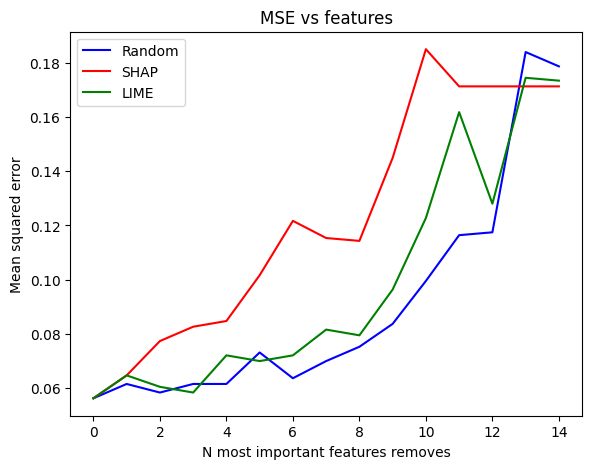

In [40]:
figmser = plt.figure()


axesmser = figmser.add_axes([0.1, 0.1, 0.8, 0.8]) 


axesmser.plot(list(range(0,15)), mser, 'b',label='Random')
axesmser.plot(list(range(0,15)), msen, 'r',label='SHAP')
axesmser.plot(list(range(0,15)), msel, 'g',label='LIME')
axesmser.set_xlabel('N most important features removes') 
axesmser.set_ylabel('Mean squared error')
axesmser.set_title('MSE vs features')
axesmser.legend()

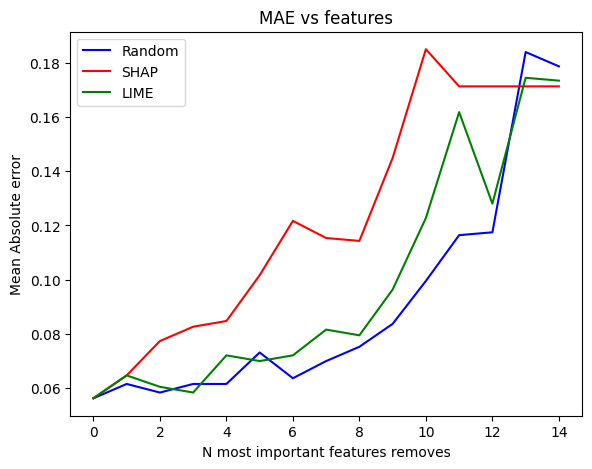

In [41]:
figmear = plt.figure()


axesmear = figmear.add_axes([0.1, 0.1, 0.8, 0.8]) 


axesmear.plot(list(range(0,15)), maer, 'b',label='Random')
axesmear.plot(list(range(0,15)), maen, 'r',label='SHAP')
axesmear.plot(list(range(0,15)), mael, 'g',label='LIME')
axesmear.set_xlabel('N most important features removes') 
axesmear.set_ylabel('Mean Absolute error')
axesmear.set_title('MAE vs features')
axesmear.legend()

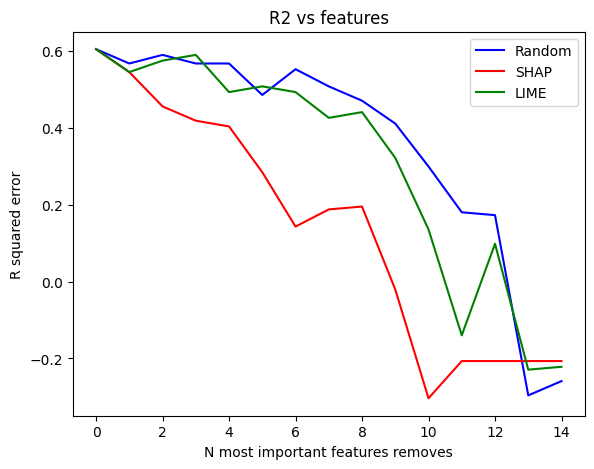

In [42]:
figr2r = plt.figure()


axesr2r = figr2r.add_axes([0.1, 0.1, 0.8, 0.8]) 


axesr2r.plot(list(range(0,15)), r2r, 'b',label='Random')
axesr2r.plot(list(range(0,15)), r2n, 'r',label='SHAP')
axesr2r.plot(list(range(0,15)), r2l, 'g',label='LIME')
axesr2r.set_xlabel('N most important features removes') 
axesr2r.set_ylabel('R squared error')
axesr2r.set_title('R2 vs features')
axesr2r.legend()

In [43]:
D3=np.zeros(15)
lmse=msel[14]-msel[0]
lmae=mael[14]-mael[0]
for i in range(15):

  X3_train=X_train.drop(return_n_imp(i),axis=1)
  X3_test=X_test.drop(return_n_imp(i),axis=1)
  rf3 = RandomForestClassifier(n_estimators=100, random_state=42) #create the model
  rf3.fit(X3_train, y_train)
  MSE3=mean_squared_error(y_test,rf3.predict(X3_test))
  MAE3=mean_absolute_error(y_test,rf3.predict(X3_test))
  R23=r2_score(y_test,rf3.predict(X3_test))
  #Dn[i]=MSE1+MAE1-R21+R2-MAE-MSE
  D3[i]=R2-R23+(MSE3-MSE)/lmse +(MAE3-MAE)/lmae

In [44]:
axesDr = figDr.add_axes([0.1, 0.1, 0.8, 0.8]) 


axesDr.plot(list(range(0,15)), D2, 'b',label='Random')
axesDr.plot(list(range(0,15)), Dn, 'r',label='SHAP')
axesDr.plot(list(range(0,15)), D3, 'g',label='LIME')
axesDr.set_xlabel('N most important features removes') 
axesDr.set_ylabel(' Degree of Change of the metrics')
axesDr.set_title('D vs features')
axesDr.legend()

In [46]:
D2m=np.mean(D2)
Dnm=np.mean(Dn)
D3m=np.mean(D3)
print(D2m)
print(Dnm)
print(D3m)

0.8065843621399177
1.613272613891265
1.5925987289971963
